<a href="https://colab.research.google.com/github/allefbcc/projetoCienciaDeDados-Walmart/blob/main/forecasting-notebook-group-6/N5_forecasting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  previsão de vendas dos 100 produtos mais vendidos no total

## Importando bibliotecas

In [ ]:
!pip install mlforecast
!pip install dill

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from mlforecast.target_transforms import LocalMinMaxScaler
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import dill as pickle
import tempfile
import os

## Carregando DataFrame

In [ ]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [ ]:
data = pd.read_parquet(bucket_uri)

In [ ]:
data

id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
59181085    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
59181086    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
59181087    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
59181088    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
59181089    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id  value        date  
0            CA_1       CA      0  2011-01-29  
1            CA_1       CA      0  2011-01-29  
2            CA_1       CA      0  2011-01-29  
3            CA_1       CA      0  2011-01-29  
4            CA_1       CA      0  2011-01-29  
...           ...      ...    ...         ...  
59181085     WI_3       WI      1  2016-05-22  
59181086     WI_3       WI      0  2016-05-22  
59181087     WI_3       WI      2  2016-05-22  
59181088     WI_3       WI      0  2016-05-22  
59181089     WI_3       WI      1  2016-05-22  

[59181090 rows x 8 columns]

In [ ]:
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data_itens = data[['date', 'item_id', 'value']]

In [ ]:
data_itens.set_index('date', inplace=True)

In [ ]:
data_itens

item_id  value
date                            
2011-01-29  HOBBIES_1_001      0
2011-01-29  HOBBIES_1_002      0
2011-01-29  HOBBIES_1_003      0
2011-01-29  HOBBIES_1_004      0
2011-01-29  HOBBIES_1_005      0
...                   ...    ...
2016-05-22    FOODS_3_823      1
2016-05-22    FOODS_3_824      0
2016-05-22    FOODS_3_825      2
2016-05-22    FOODS_3_826      0
2016-05-22    FOODS_3_827      1

[59181090 rows x 2 columns]

## Agrupando dados por Item

In [ ]:
data_itens_agrupado = data_itens.groupby('item_id')['value'].sum().reset_index()

/var/tmp/ipykernel_5389/318347755.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_itens_agrupado = data_itens.groupby('item_id')['value'].sum().reset_index()


In [ ]:
data_itens_agrupado = data_itens_agrupado.sort_values(by='value', ascending=False).reset_index(drop=True)

In [ ]:
data_itens_agrupado

item_id    value
0         FOODS_3_090  1017916
1         FOODS_3_586   932236
2         FOODS_3_252   573723
3         FOODS_3_555   497881
4         FOODS_3_587   402159
...               ...      ...
3044    HOBBIES_2_084      786
3045  HOUSEHOLD_2_005      782
3046  HOUSEHOLD_2_175      759
3047    HOBBIES_2_119      673
3048  HOUSEHOLD_2_101      593

[3049 rows x 2 columns]

In [ ]:
data_itens_top100 = data_itens_agrupado.head(100)

In [ ]:
data_itens_top100

item_id    value
0       FOODS_3_090  1017916
1       FOODS_3_586   932236
2       FOODS_3_252   573723
3       FOODS_3_555   497881
4       FOODS_3_587   402159
..              ...      ...
95  HOUSEHOLD_1_277   108492
96    HOBBIES_1_348   107234
97      FOODS_2_347   107207
98  HOUSEHOLD_1_409   106858
99      FOODS_3_154   102725

[100 rows x 2 columns]

In [ ]:
lista_itens_top100 = data_itens_top100['item_id'].tolist()

In [ ]:
data_itens_top100 = data_itens[data_itens['item_id'].isin(lista_itens_top100)]

In [ ]:
data_itens_top100

item_id  value
date                              
2011-01-29    HOBBIES_1_348      9
2011-01-29    HOBBIES_1_371     14
2011-01-29  HOUSEHOLD_1_019      0
2011-01-29  HOUSEHOLD_1_083      2
2011-01-29  HOUSEHOLD_1_110      0
...                     ...    ...
2016-05-22      FOODS_3_764      6
2016-05-22      FOODS_3_785     31
2016-05-22      FOODS_3_804     16
2016-05-22      FOODS_3_808      0
2016-05-22      FOODS_3_811     31

[1941000 rows x 2 columns]

In [ ]:
data_itens_top100 = (data_itens_top100
                        .groupby('item_id')
                        .resample('D')
                        .sum()
                        .reset_index())

/var/tmp/ipykernel_5389/1118912900.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('item_id')


In [ ]:
data_itens_top100

item_id       date  value
0           FOODS_1_004 2011-01-29      0
1           FOODS_1_004 2011-01-30      0
2           FOODS_1_004 2011-01-31      0
3           FOODS_1_004 2011-02-01      0
4           FOODS_1_004 2011-02-02      0
...                 ...        ...    ...
194095  HOUSEHOLD_1_521 2016-05-18     46
194096  HOUSEHOLD_1_521 2016-05-19     34
194097  HOUSEHOLD_1_521 2016-05-20     74
194098  HOUSEHOLD_1_521 2016-05-21     67
194099  HOUSEHOLD_1_521 2016-05-22     47

[194100 rows x 3 columns]

In [ ]:
data_itens_top100 =  data_itens_top100.rename(columns={'date': 'ds', 'value': 'y', 'item_id': 'unique_id'})

In [ ]:
data_itens_top100

unique_id         ds   y
0           FOODS_1_004 2011-01-29   0
1           FOODS_1_004 2011-01-30   0
2           FOODS_1_004 2011-01-31   0
3           FOODS_1_004 2011-02-01   0
4           FOODS_1_004 2011-02-02   0
...                 ...        ...  ..
194095  HOUSEHOLD_1_521 2016-05-18  46
194096  HOUSEHOLD_1_521 2016-05-19  34
194097  HOUSEHOLD_1_521 2016-05-20  74
194098  HOUSEHOLD_1_521 2016-05-21  67
194099  HOUSEHOLD_1_521 2016-05-22  47

[194100 rows x 3 columns]

## dividindo dados em treinamento e teste

In [ ]:
train_list = []
test_list = []

for state in data_itens_top100['unique_id'].unique():
    state_data = data_itens_top100[data_itens_top100['unique_id'] == state]
    train, test = train_test_split(state_data, test_size=0.2, shuffle=False) # shuffle=False mantém a ordem temporal
    train_list.append(train)
    test_list.append(test)

In [ ]:
data_train = pd.concat(train_list)
data_test = pd.concat(test_list)

# Resetando os índices dos dataframes resultantes
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [ ]:
data_train

unique_id         ds   y
0           FOODS_1_004 2011-01-29   0
1           FOODS_1_004 2011-01-30   0
2           FOODS_1_004 2011-01-31   0
3           FOODS_1_004 2011-02-01   0
4           FOODS_1_004 2011-02-02   0
...                 ...        ...  ..
155195  HOUSEHOLD_1_521 2015-04-25  89
155196  HOUSEHOLD_1_521 2015-04-26  97
155197  HOUSEHOLD_1_521 2015-04-27  73
155198  HOUSEHOLD_1_521 2015-04-28  92
155199  HOUSEHOLD_1_521 2015-04-29  84

[155200 rows x 3 columns]

In [ ]:
data_test

unique_id         ds    y
0          FOODS_1_004 2015-04-30  105
1          FOODS_1_004 2015-05-01  157
2          FOODS_1_004 2015-05-02  139
3          FOODS_1_004 2015-05-03  127
4          FOODS_1_004 2015-05-04  121
...                ...        ...  ...
38895  HOUSEHOLD_1_521 2016-05-18   46
38896  HOUSEHOLD_1_521 2016-05-19   34
38897  HOUSEHOLD_1_521 2016-05-20   74
38898  HOUSEHOLD_1_521 2016-05-21   67
38899  HOUSEHOLD_1_521 2016-05-22   47

[38900 rows x 3 columns]

In [ ]:
data_full = pd.concat([data_train, data_test])

## Analisando o gráfico de autocorrelação

In [ ]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

ACF e PACF para o estado: FOODS_1_004


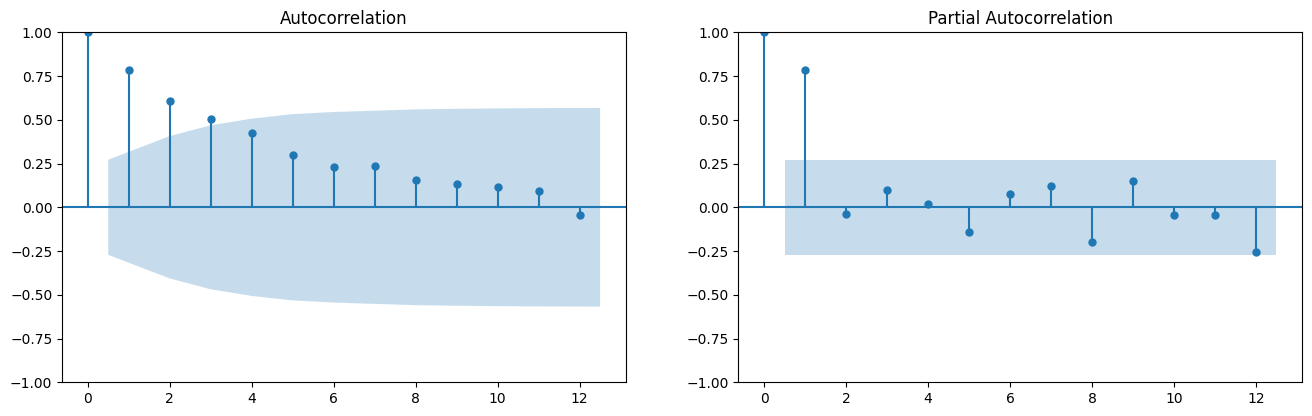

ACF e PACF para o estado: FOODS_1_018


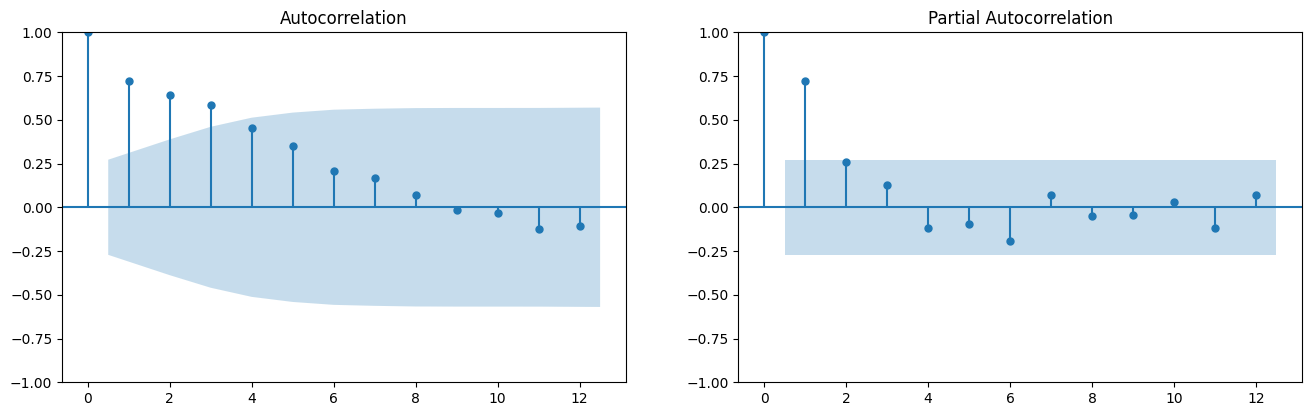

ACF e PACF para o estado: FOODS_1_032


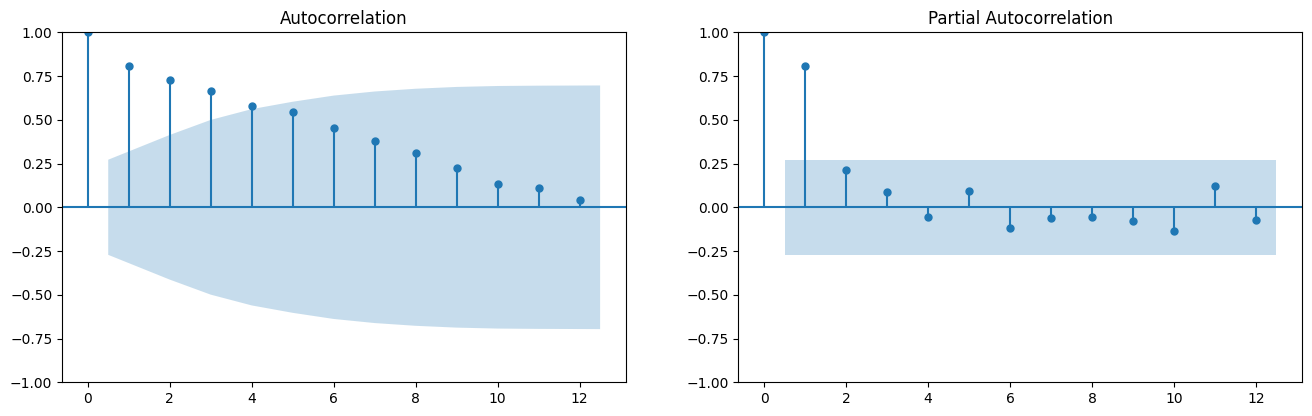

ACF e PACF para o estado: FOODS_1_043


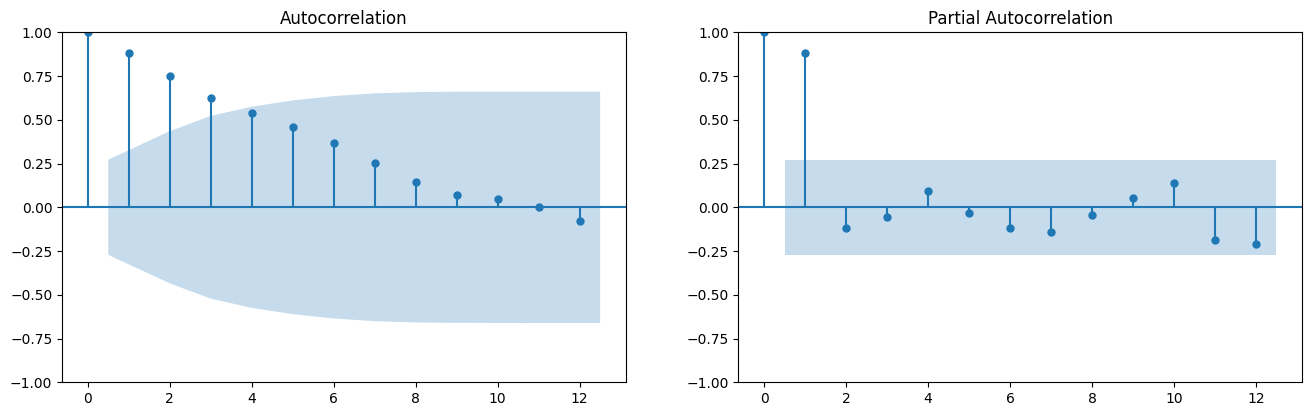

ACF e PACF para o estado: FOODS_1_046


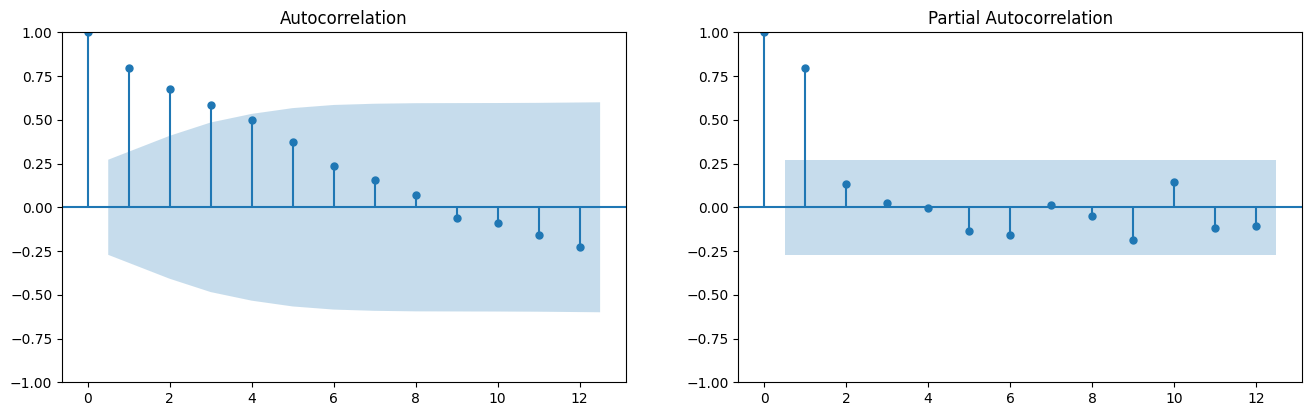

ACF e PACF para o estado: FOODS_1_085


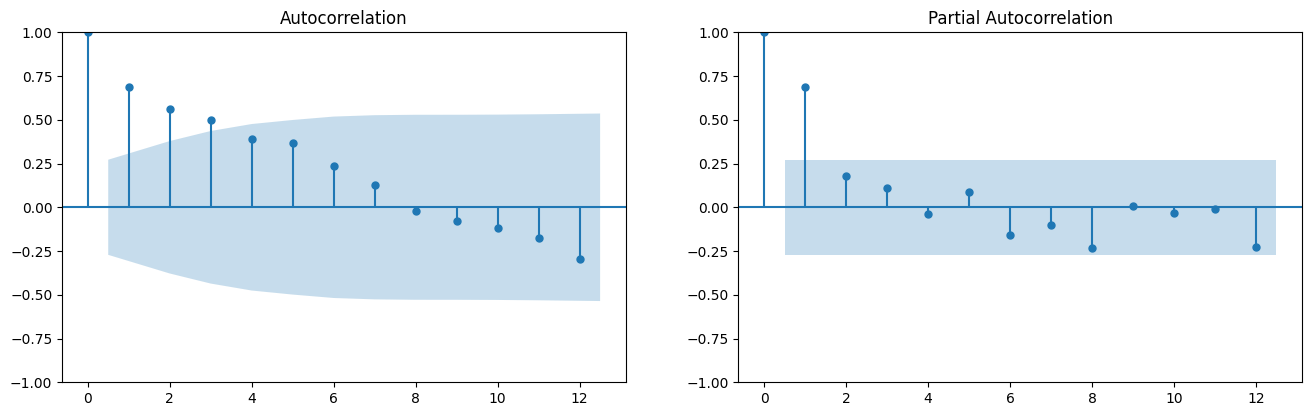

ACF e PACF para o estado: FOODS_1_218


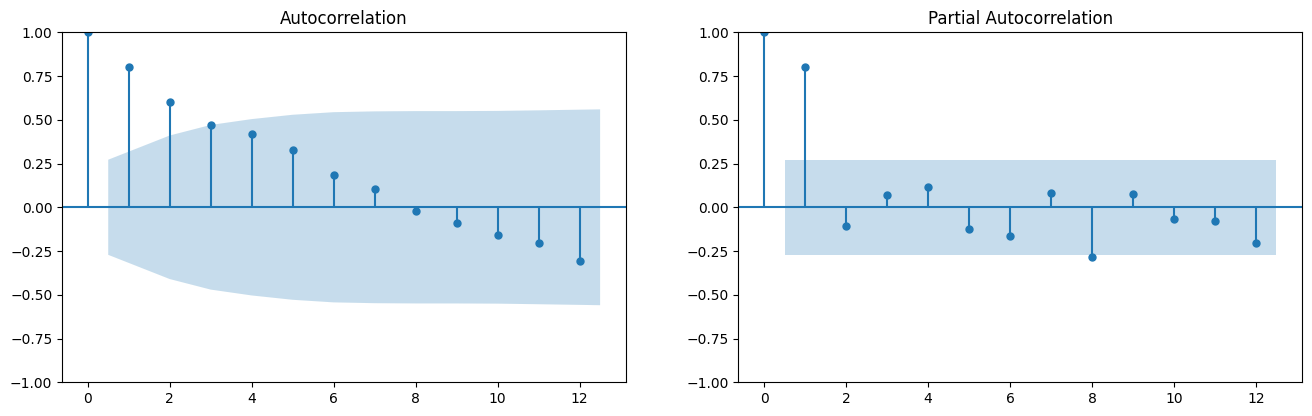

ACF e PACF para o estado: FOODS_2_021


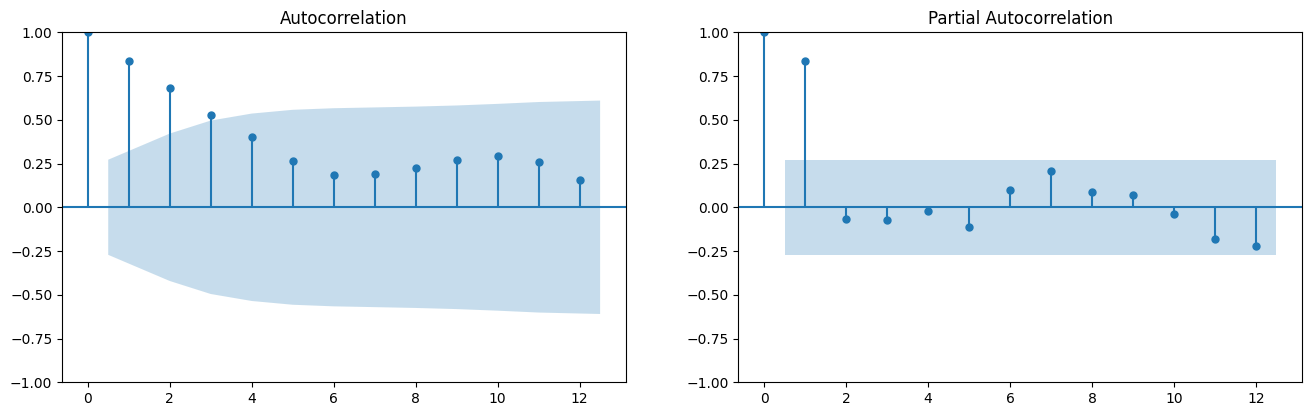

ACF e PACF para o estado: FOODS_2_128


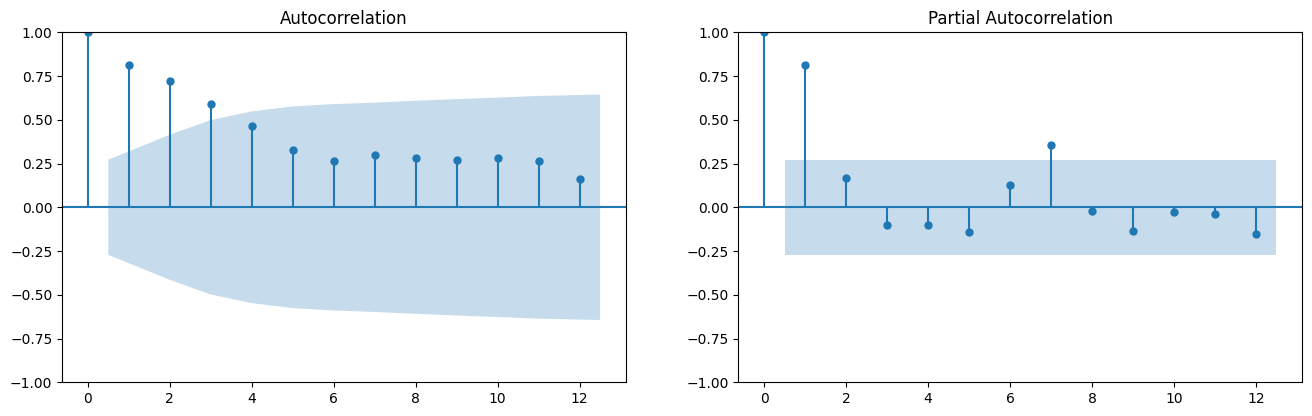

ACF e PACF para o estado: FOODS_2_181


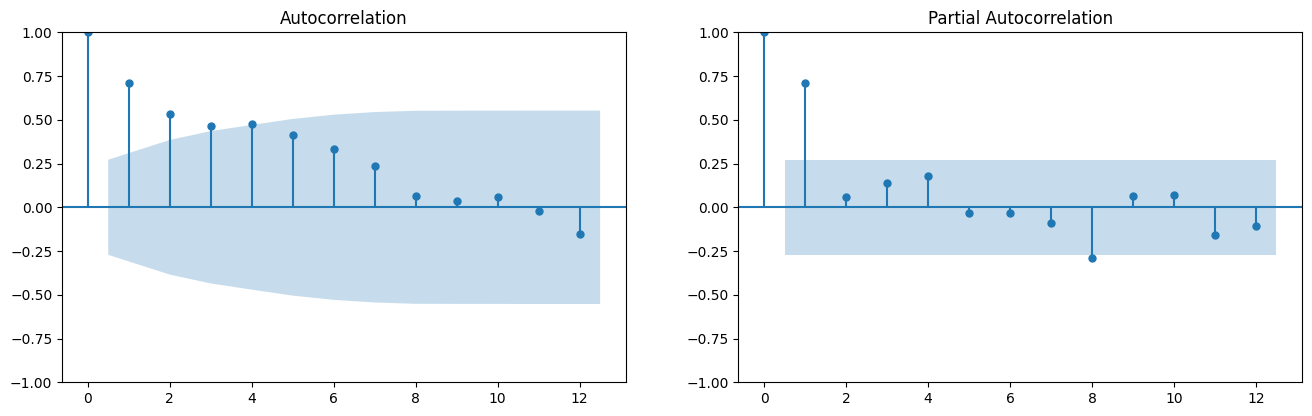

ACF e PACF para o estado: FOODS_2_197


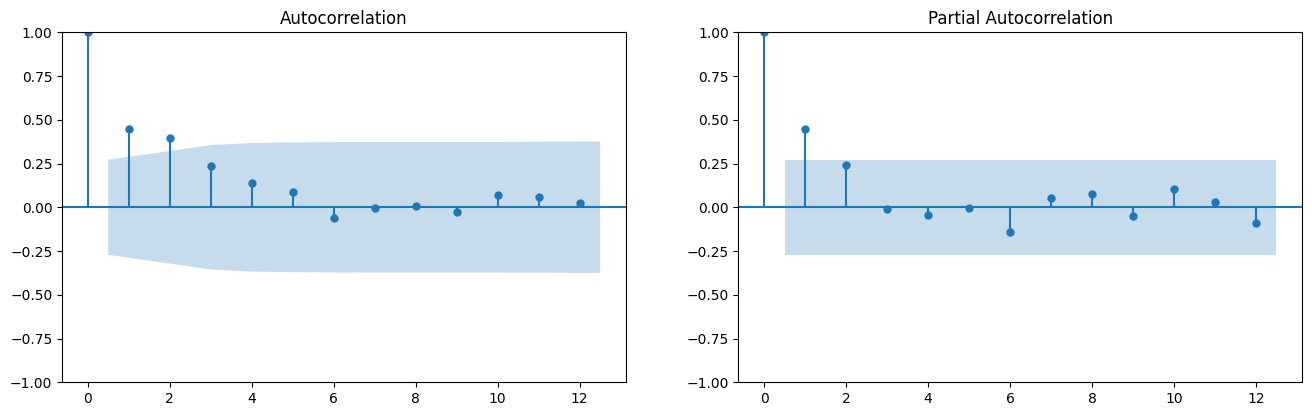

ACF e PACF para o estado: FOODS_2_276


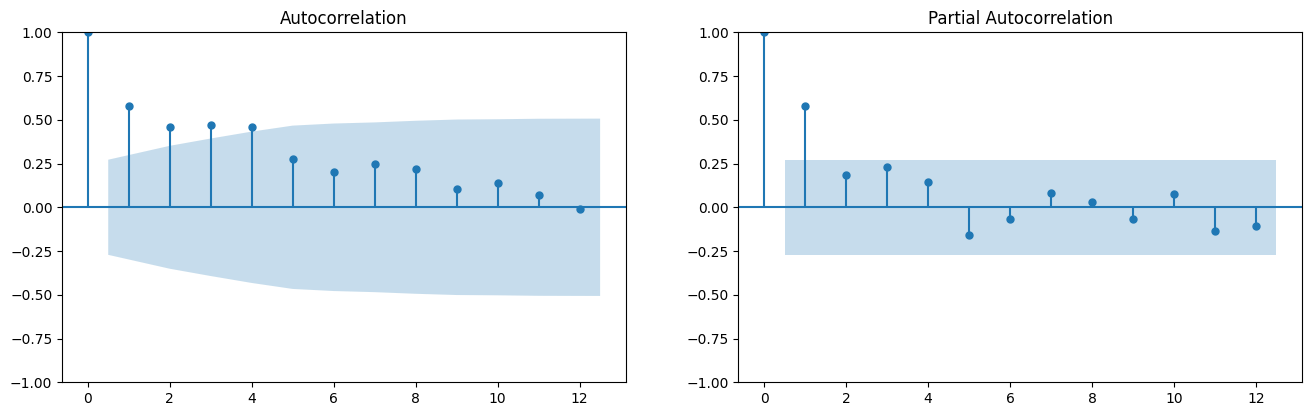

ACF e PACF para o estado: FOODS_2_326


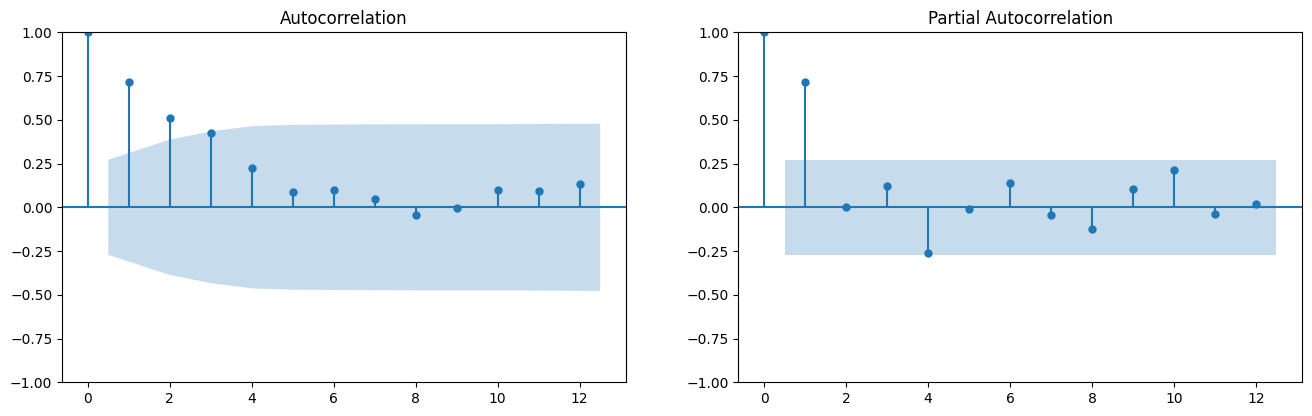

ACF e PACF para o estado: FOODS_2_347


ACF e PACF para o estado: FOODS_2_360


ACF e PACF para o estado: FOODS_3_007


ACF e PACF para o estado: FOODS_3_030


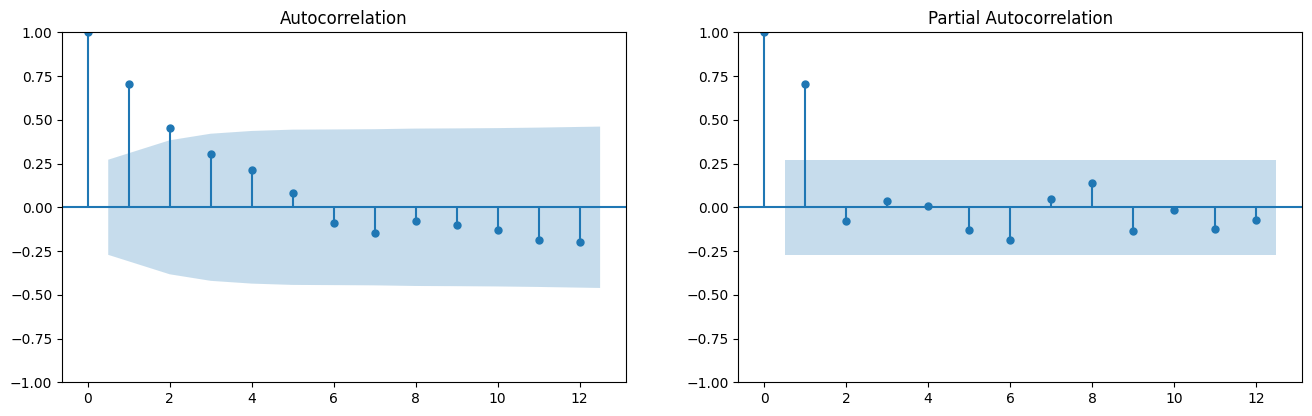

ACF e PACF para o estado: FOODS_3_080


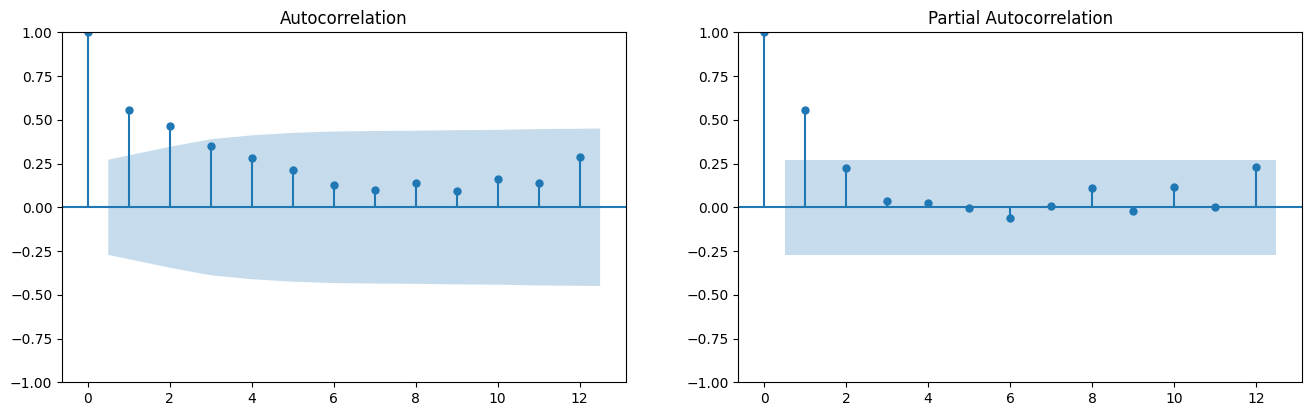

ACF e PACF para o estado: FOODS_3_086


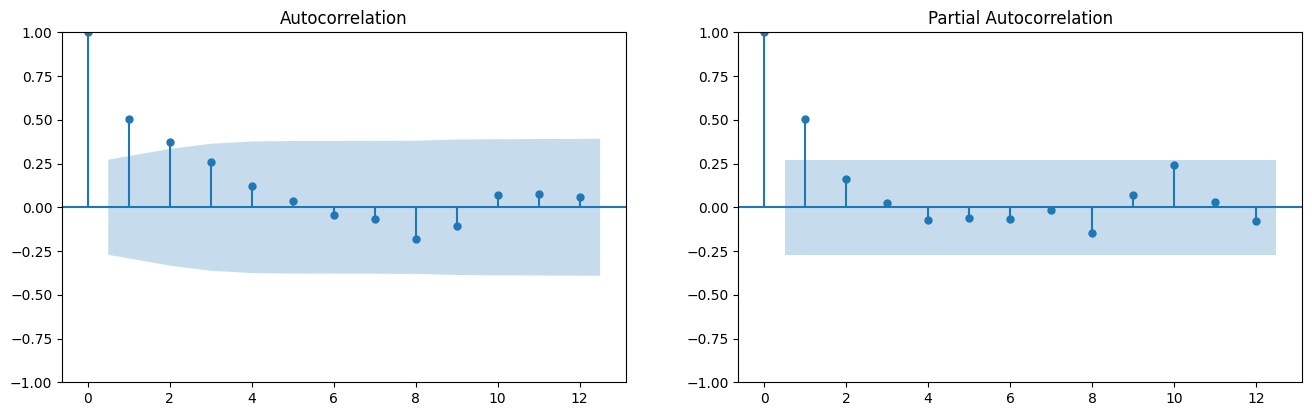

ACF e PACF para o estado: FOODS_3_090


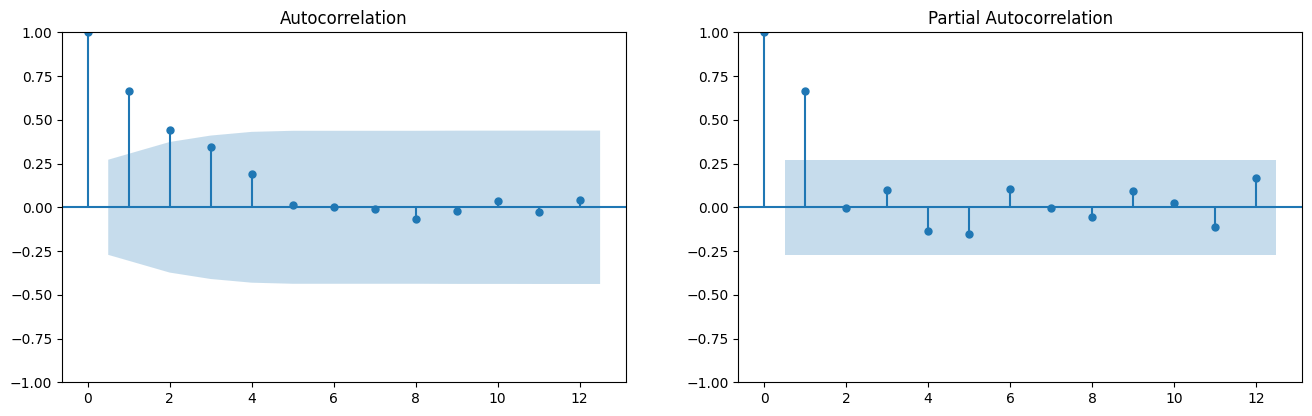

ACF e PACF para o estado: FOODS_3_099


ACF e PACF para o estado: FOODS_3_109


ACF e PACF para o estado: FOODS_3_120


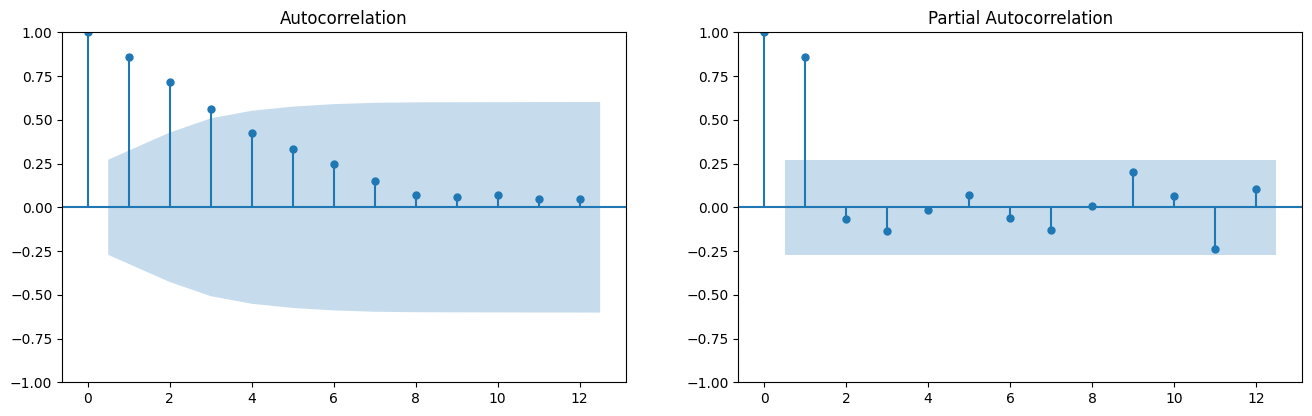

ACF e PACF para o estado: FOODS_3_150


ACF e PACF para o estado: FOODS_3_154


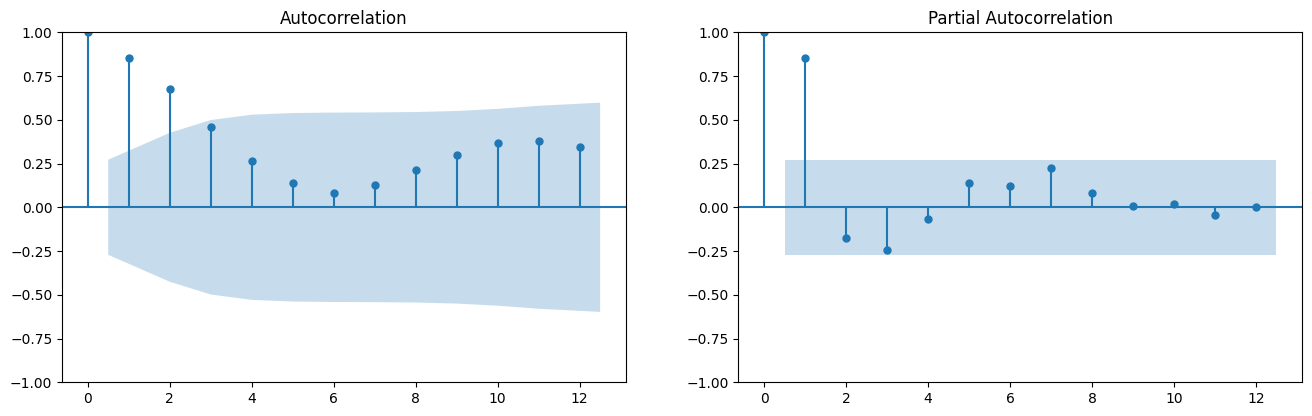

ACF e PACF para o estado: FOODS_3_202


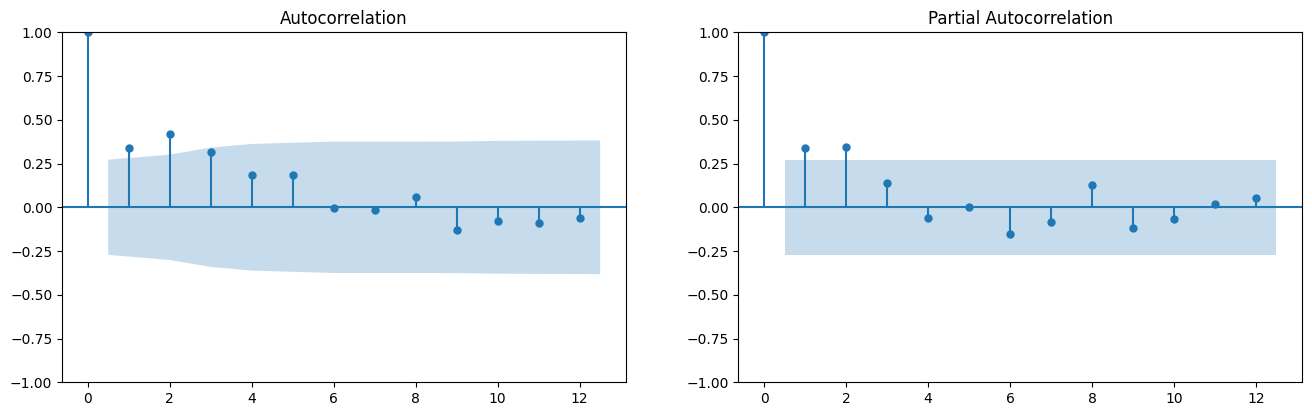

ACF e PACF para o estado: FOODS_3_226


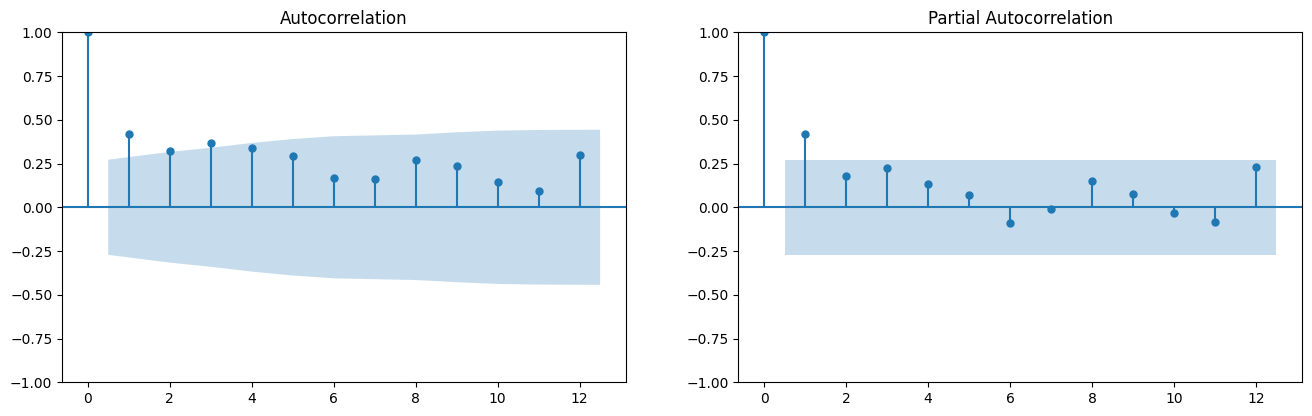

ACF e PACF para o estado: FOODS_3_228


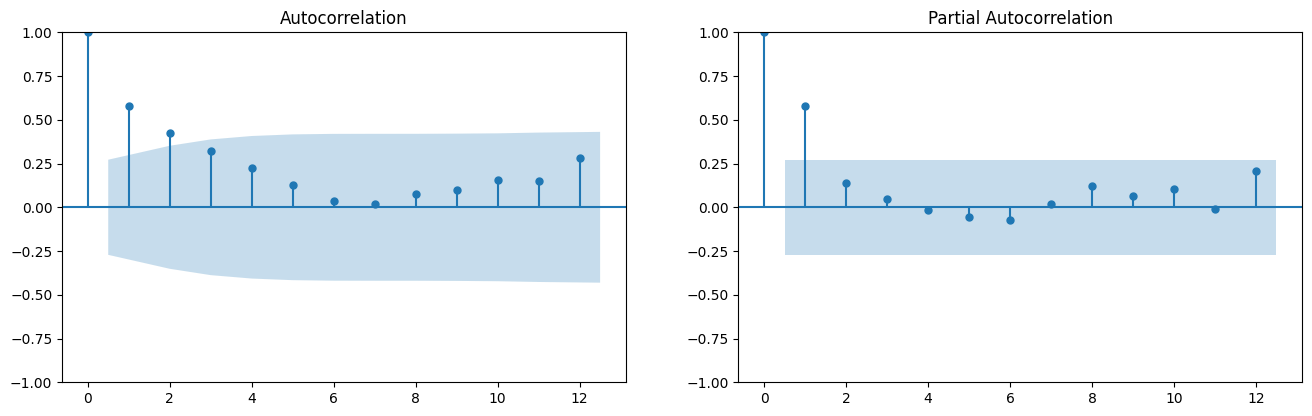

ACF e PACF para o estado: FOODS_3_234


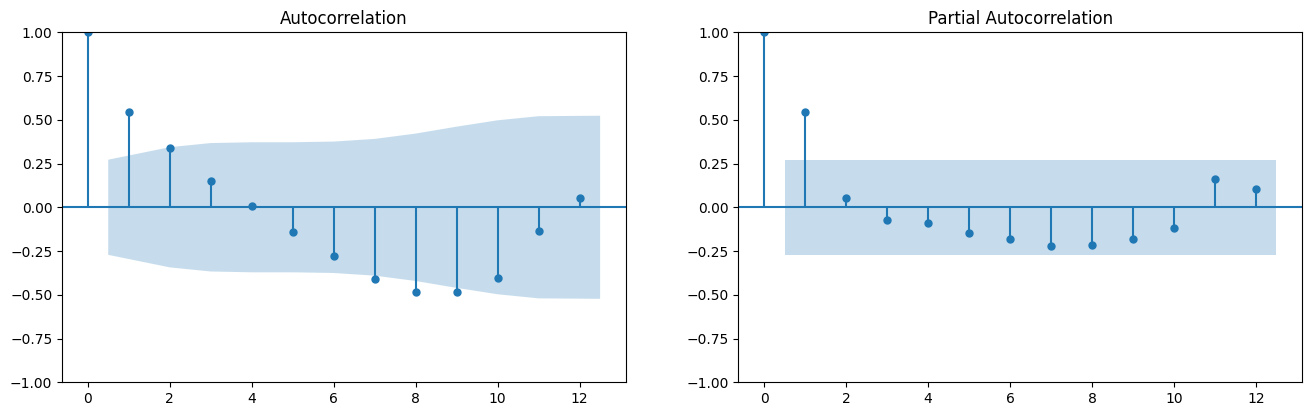

ACF e PACF para o estado: FOODS_3_252


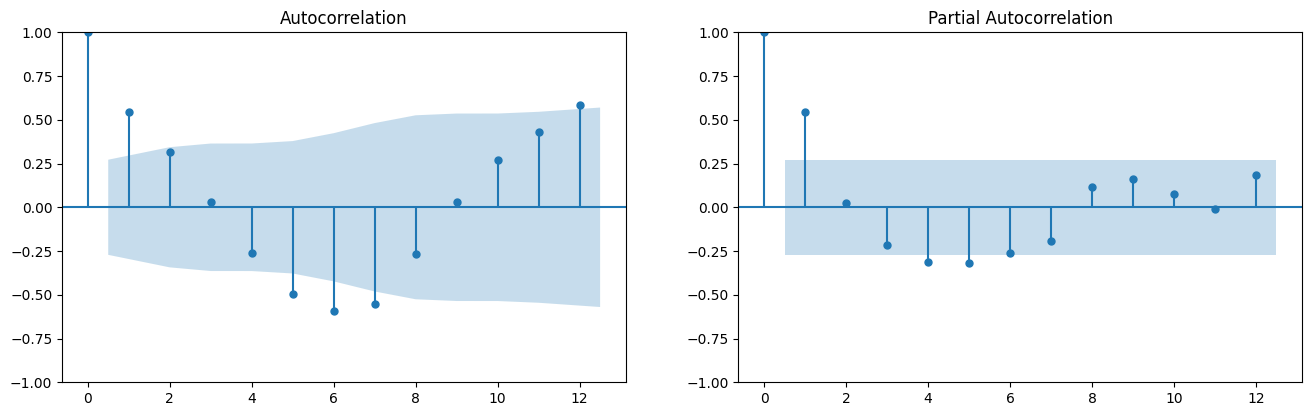

ACF e PACF para o estado: FOODS_3_281


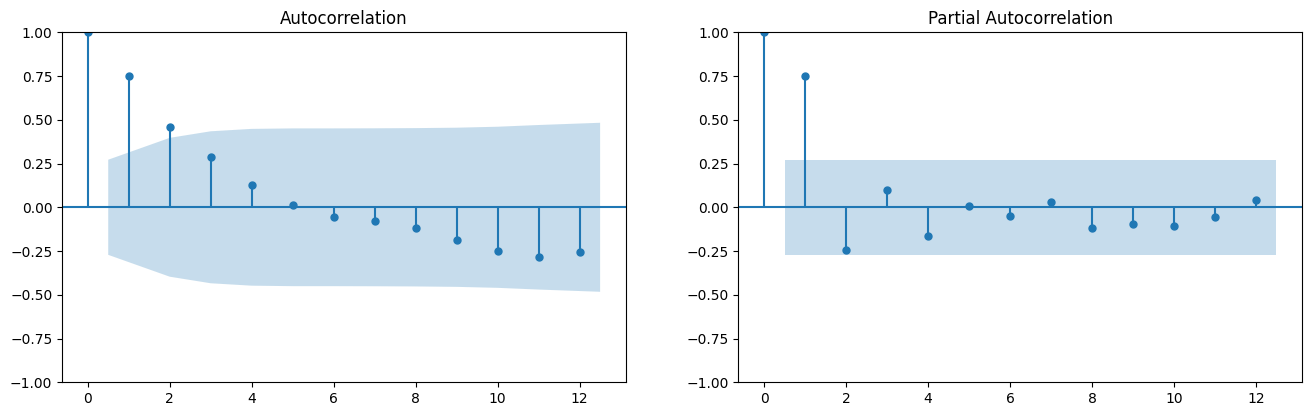

ACF e PACF para o estado: FOODS_3_282


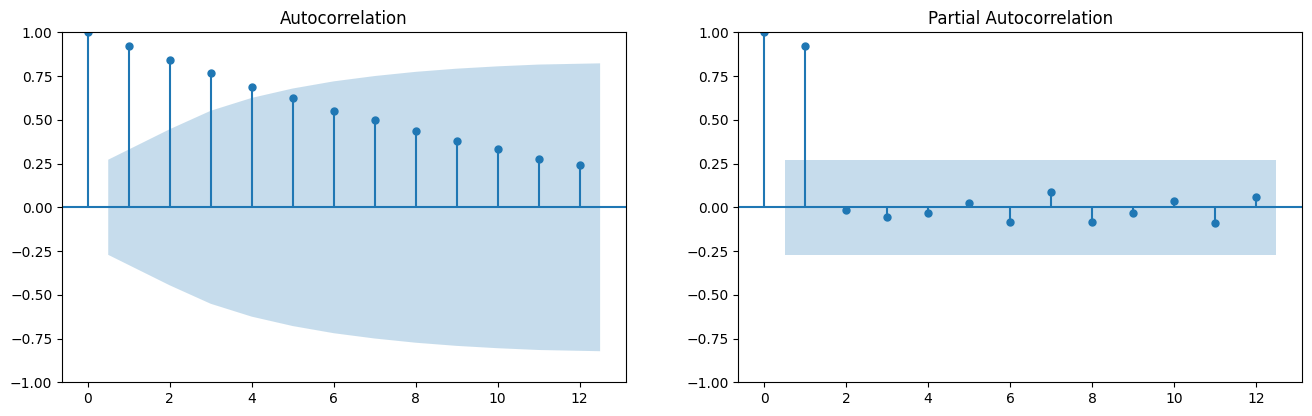

ACF e PACF para o estado: FOODS_3_288


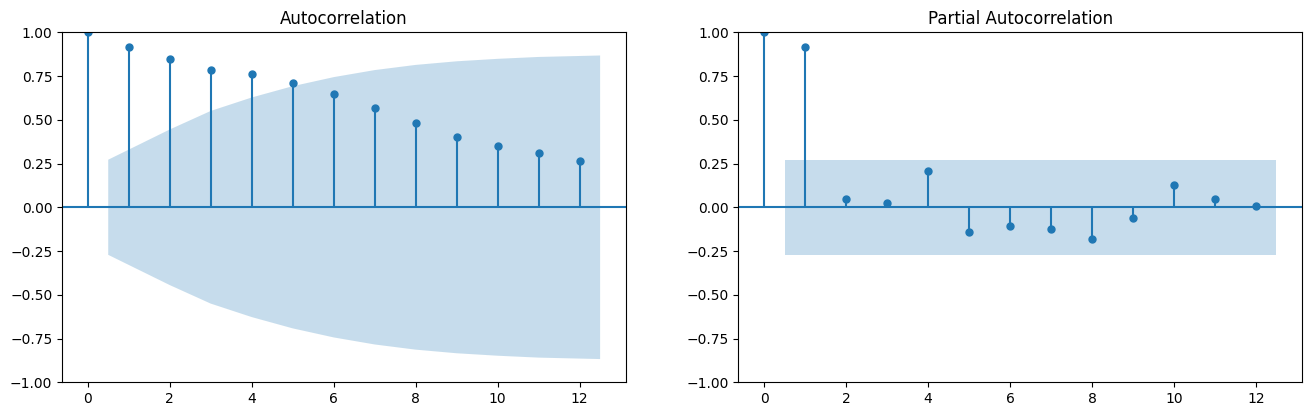

ACF e PACF para o estado: FOODS_3_295


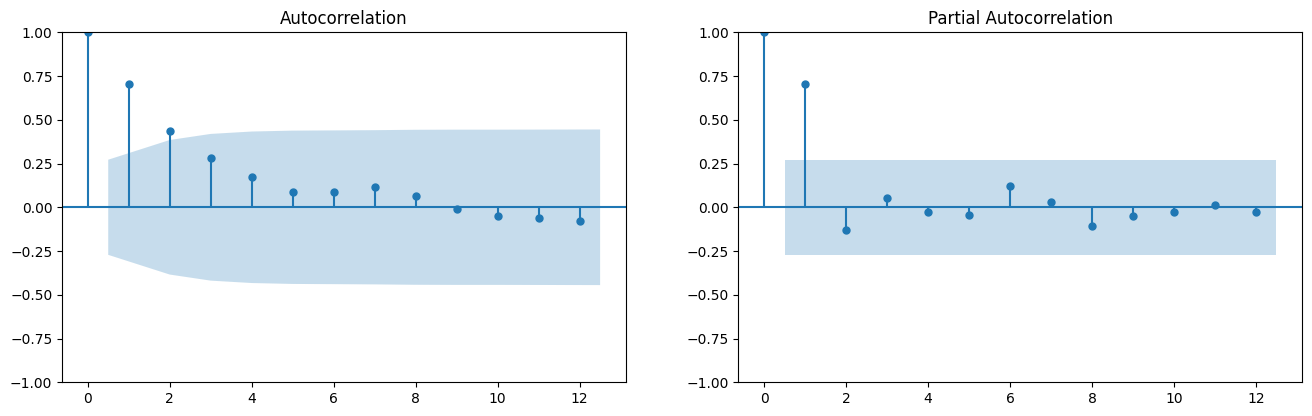

ACF e PACF para o estado: FOODS_3_318


ACF e PACF para o estado: FOODS_3_319


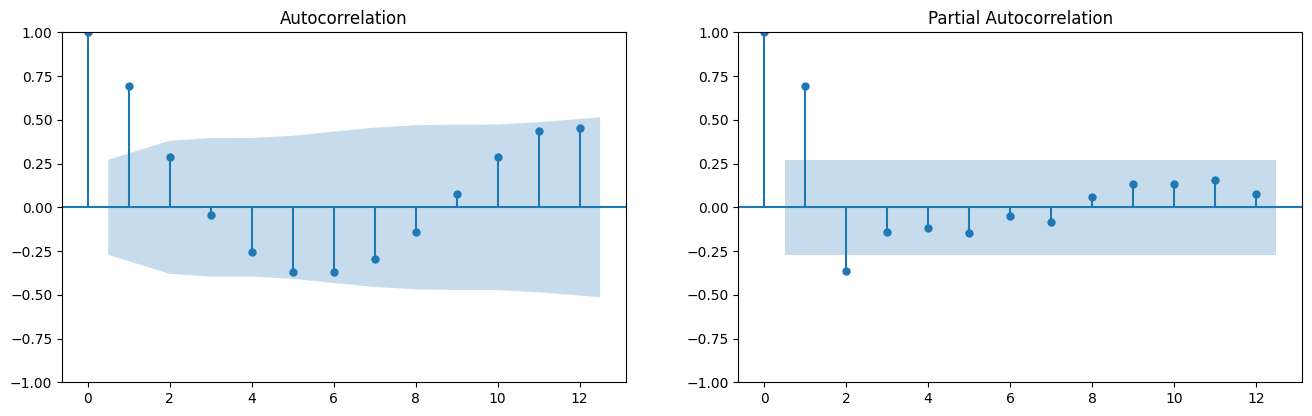

ACF e PACF para o estado: FOODS_3_329


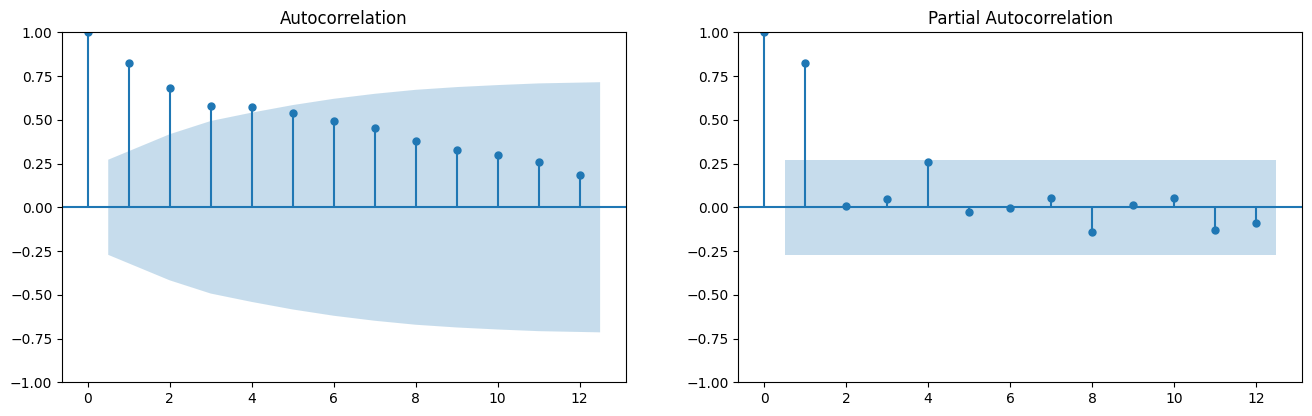

ACF e PACF para o estado: FOODS_3_348


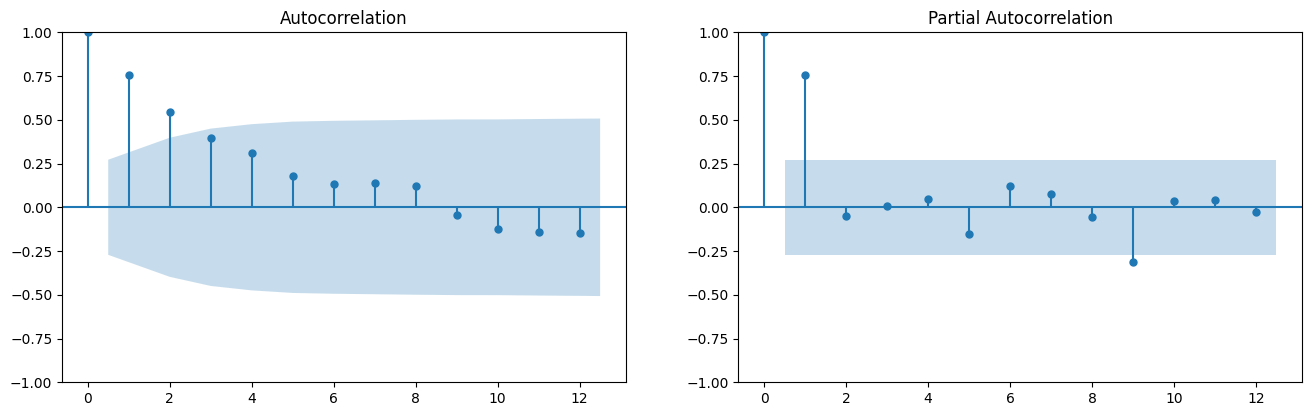

ACF e PACF para o estado: FOODS_3_362


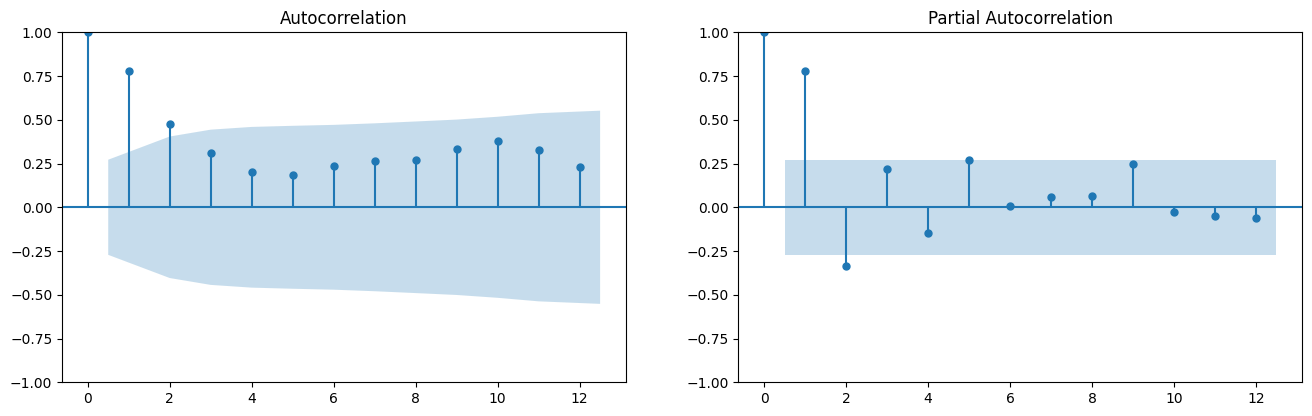

ACF e PACF para o estado: FOODS_3_376


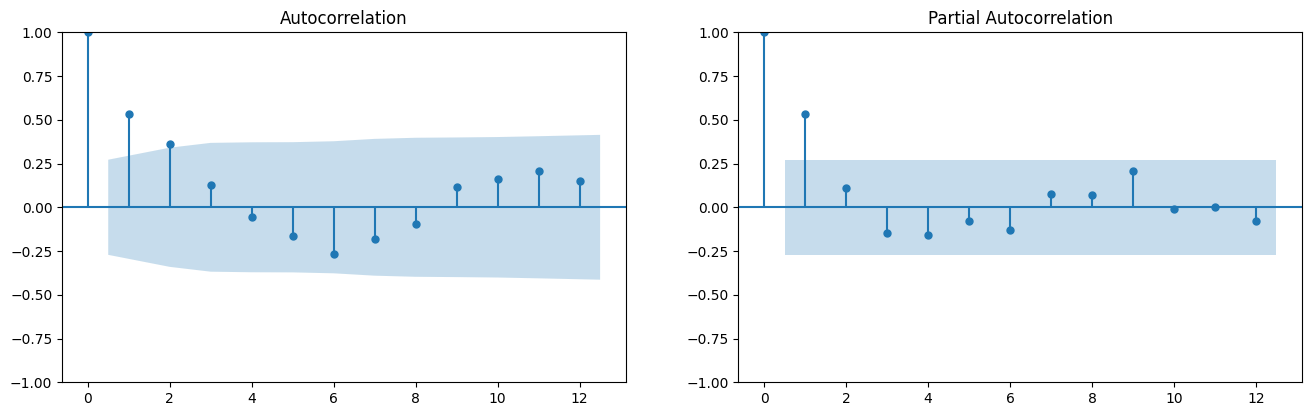

ACF e PACF para o estado: FOODS_3_377


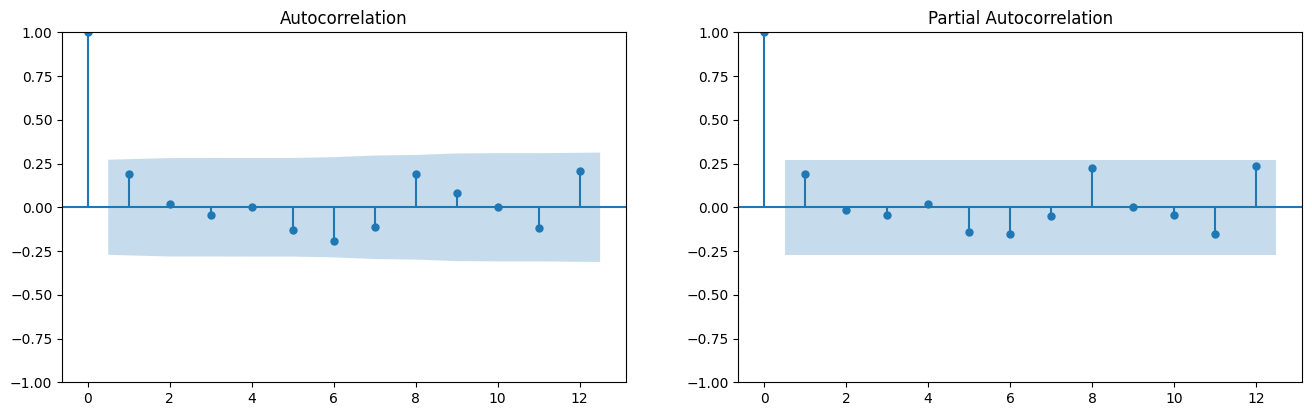

ACF e PACF para o estado: FOODS_3_389


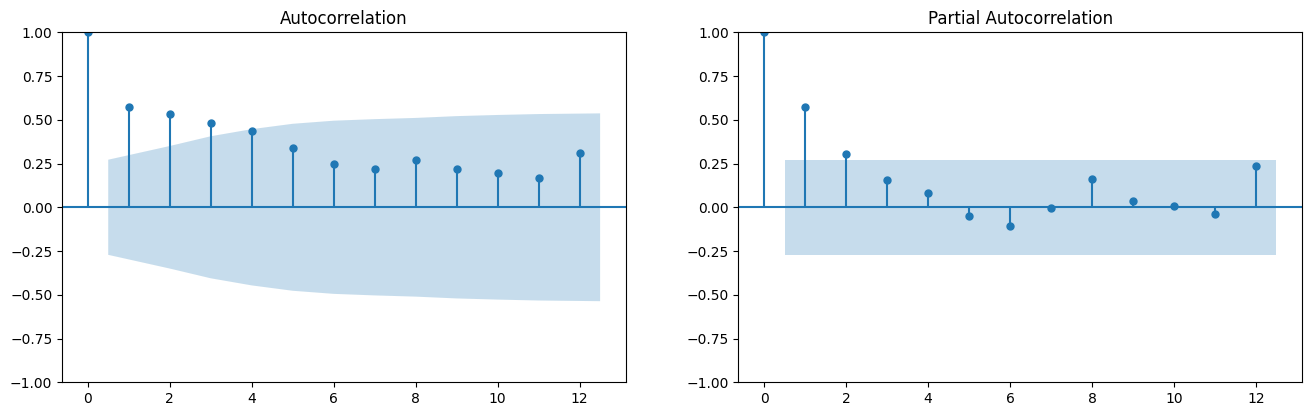

ACF e PACF para o estado: FOODS_3_404


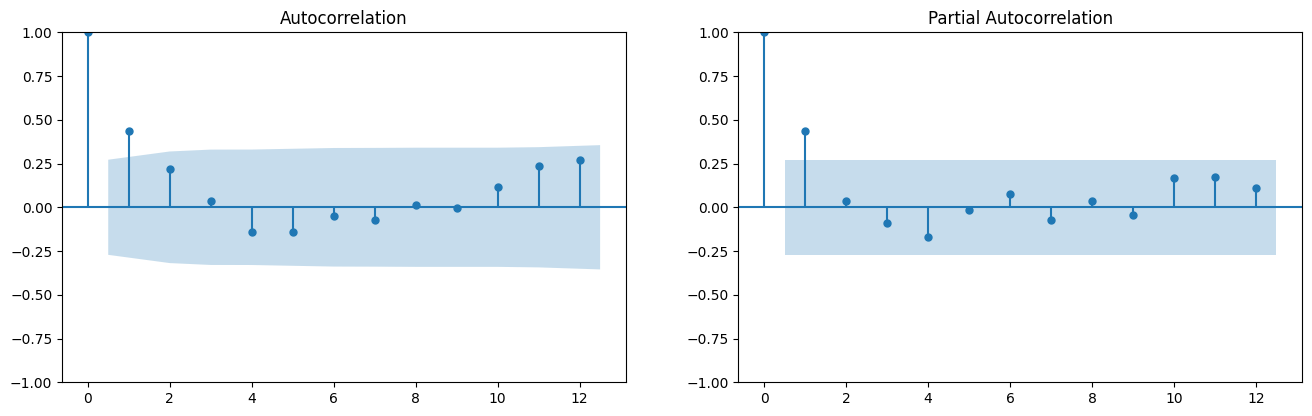

ACF e PACF para o estado: FOODS_3_406


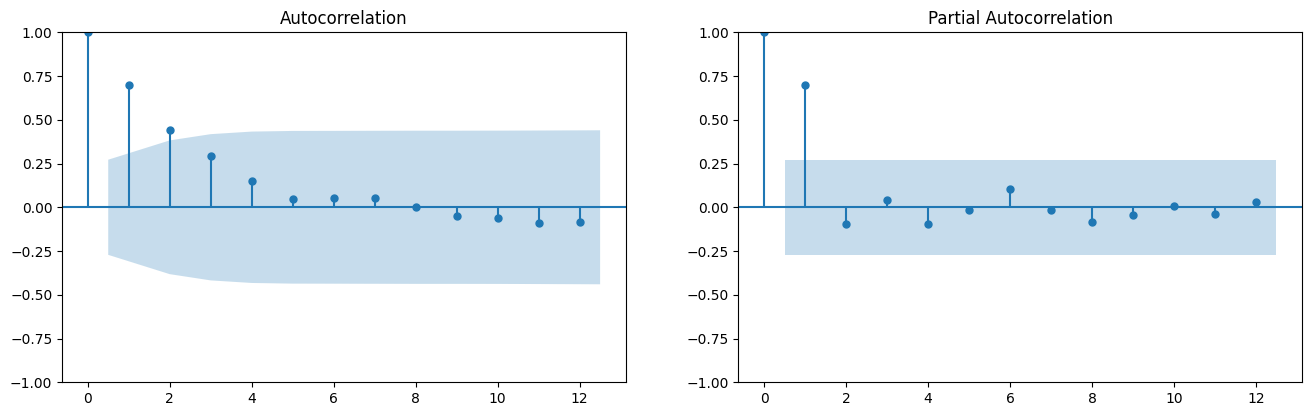

ACF e PACF para o estado: FOODS_3_412


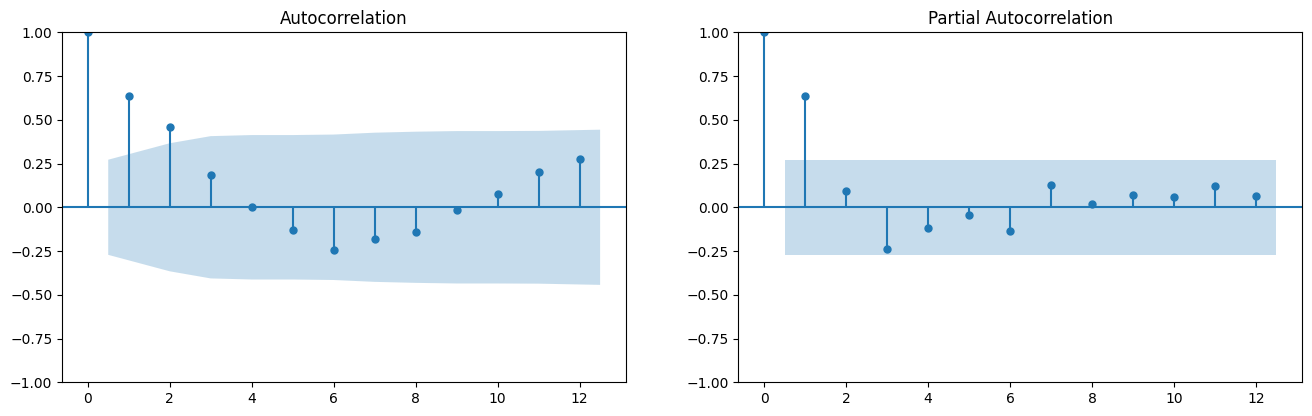

ACF e PACF para o estado: FOODS_3_444


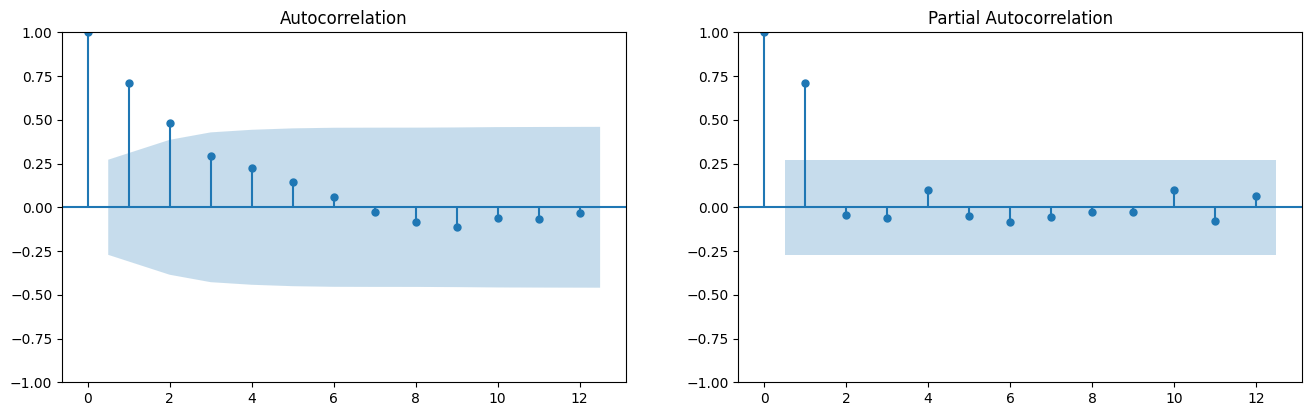

ACF e PACF para o estado: FOODS_3_455


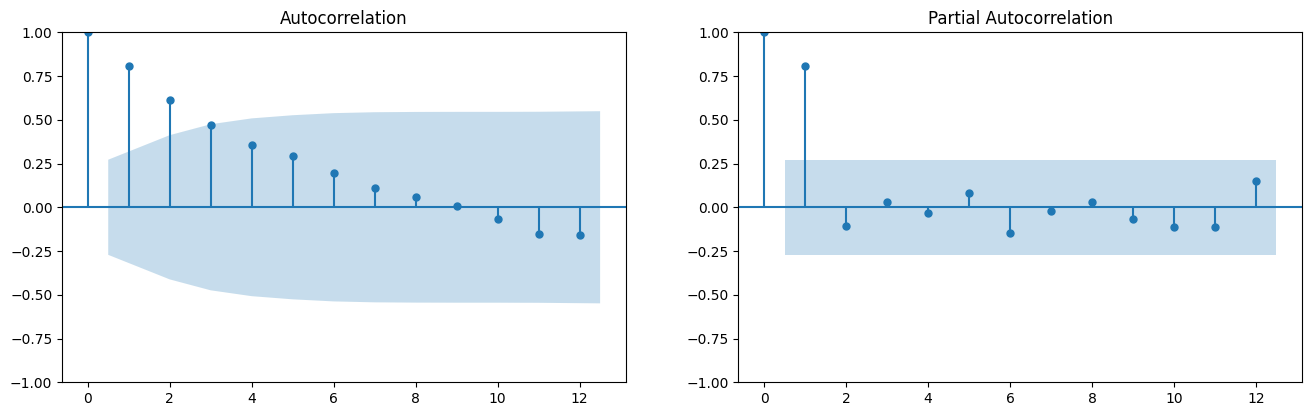

ACF e PACF para o estado: FOODS_3_458


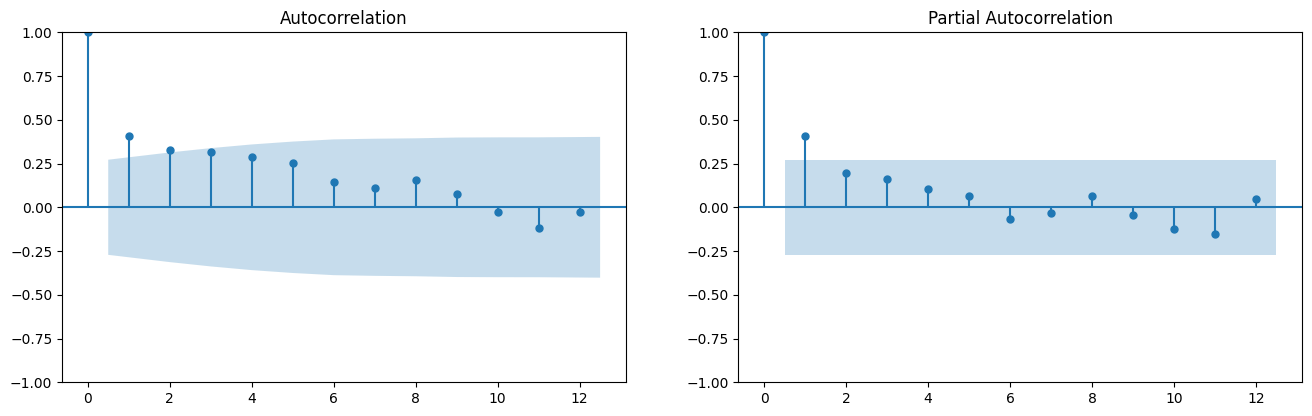

ACF e PACF para o estado: FOODS_3_462


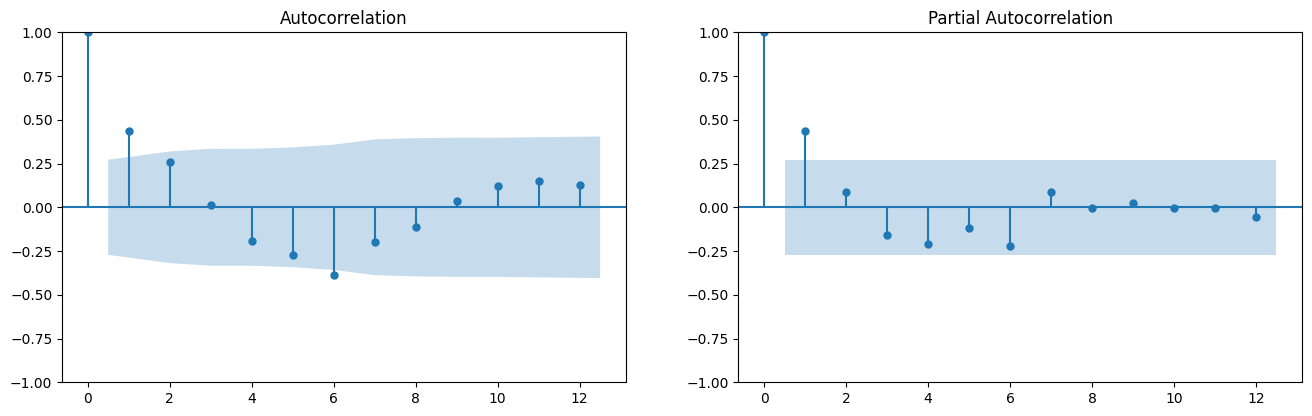

ACF e PACF para o estado: FOODS_3_491


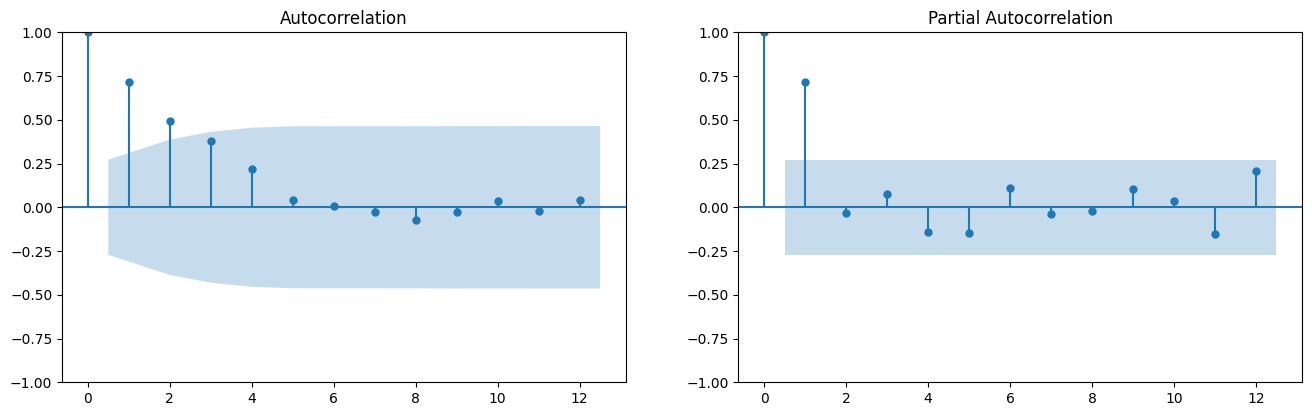

ACF e PACF para o estado: FOODS_3_498


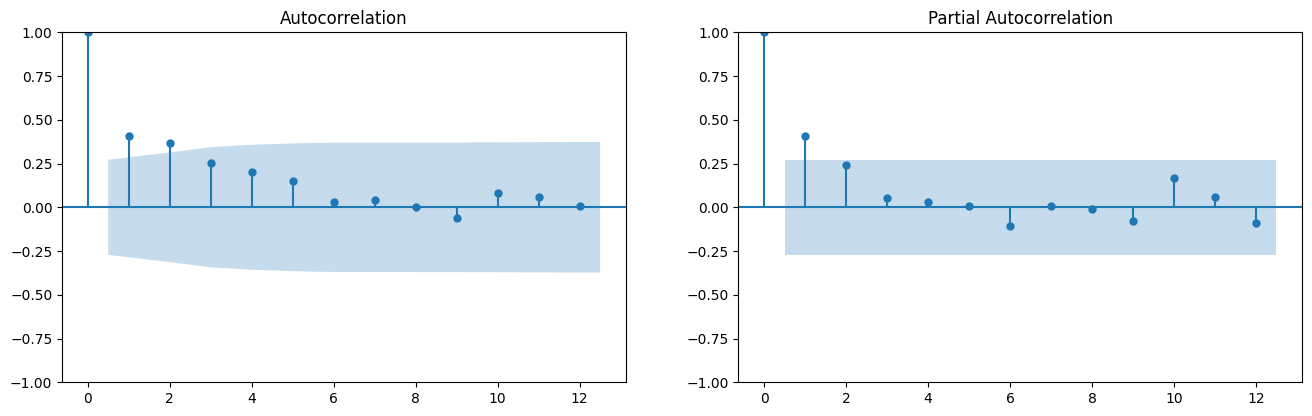

ACF e PACF para o estado: FOODS_3_499


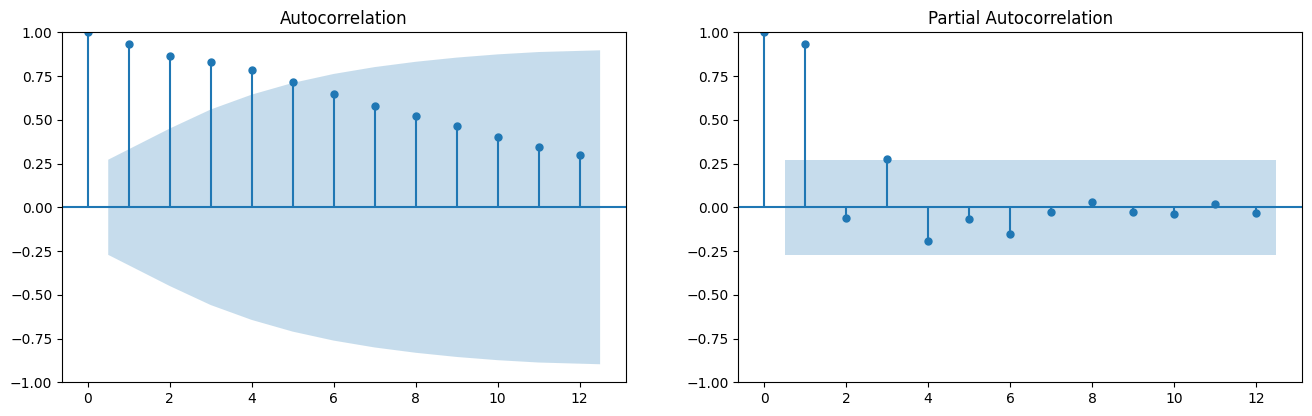

ACF e PACF para o estado: FOODS_3_501


ACF e PACF para o estado: FOODS_3_516


ACF e PACF para o estado: FOODS_3_541


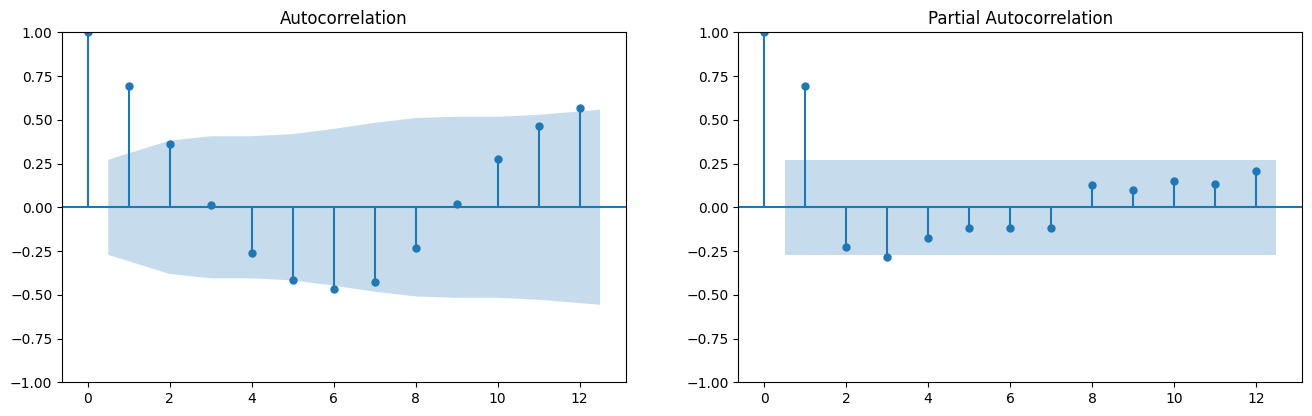

ACF e PACF para o estado: FOODS_3_547


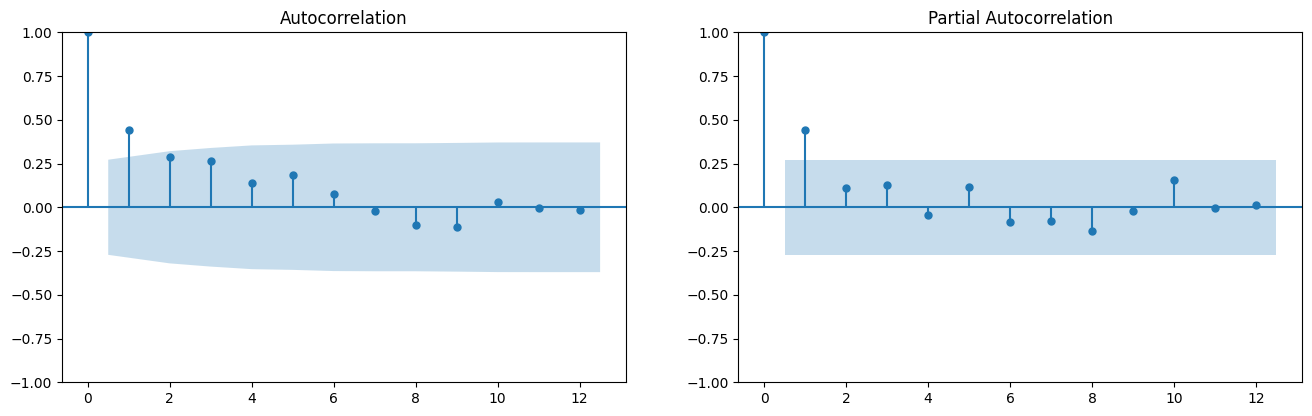

ACF e PACF para o estado: FOODS_3_555


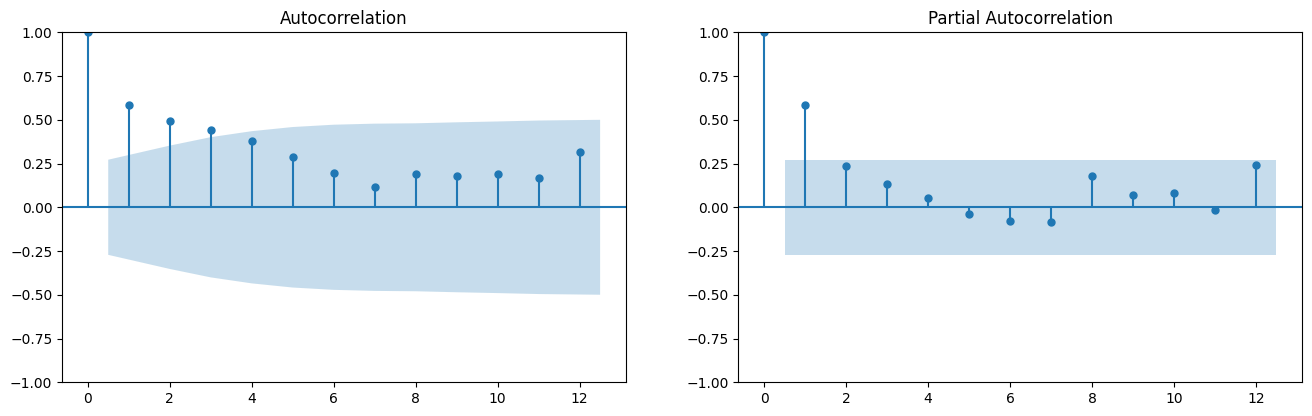

ACF e PACF para o estado: FOODS_3_580


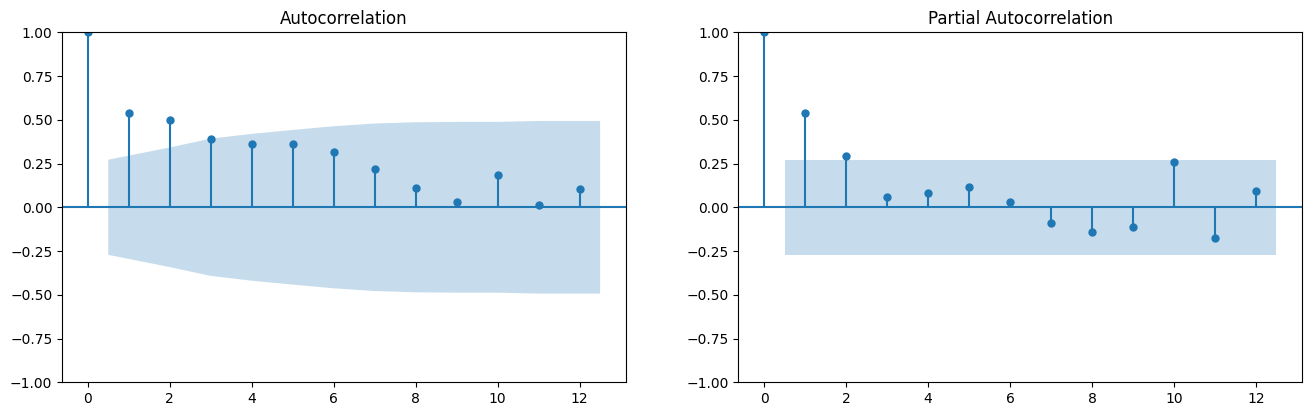

ACF e PACF para o estado: FOODS_3_586


ACF e PACF para o estado: FOODS_3_587


ACF e PACF para o estado: FOODS_3_607


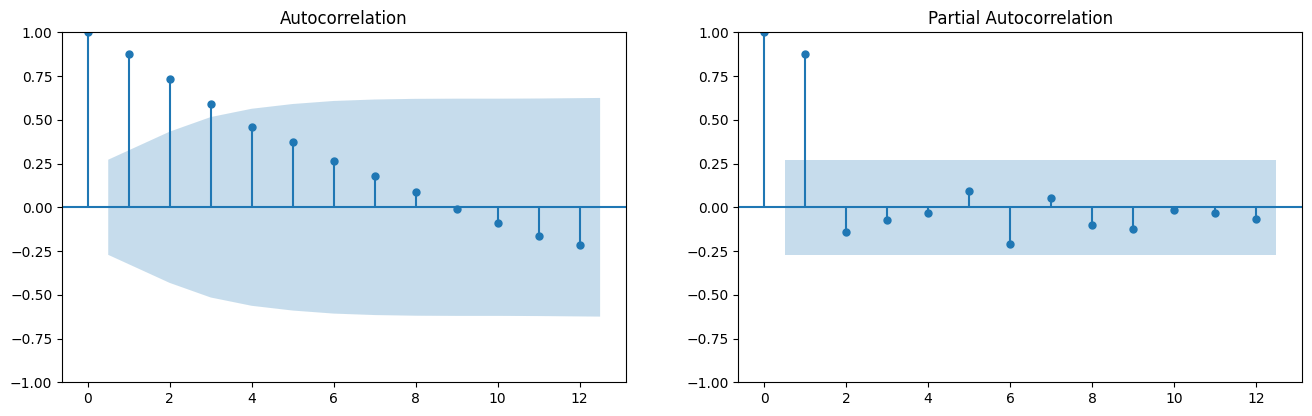

ACF e PACF para o estado: FOODS_3_635


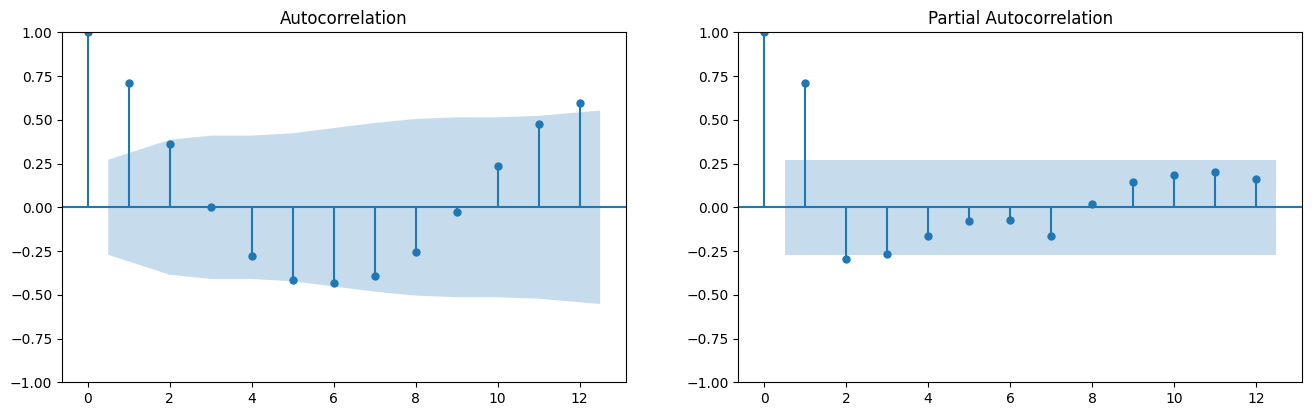

ACF e PACF para o estado: FOODS_3_668


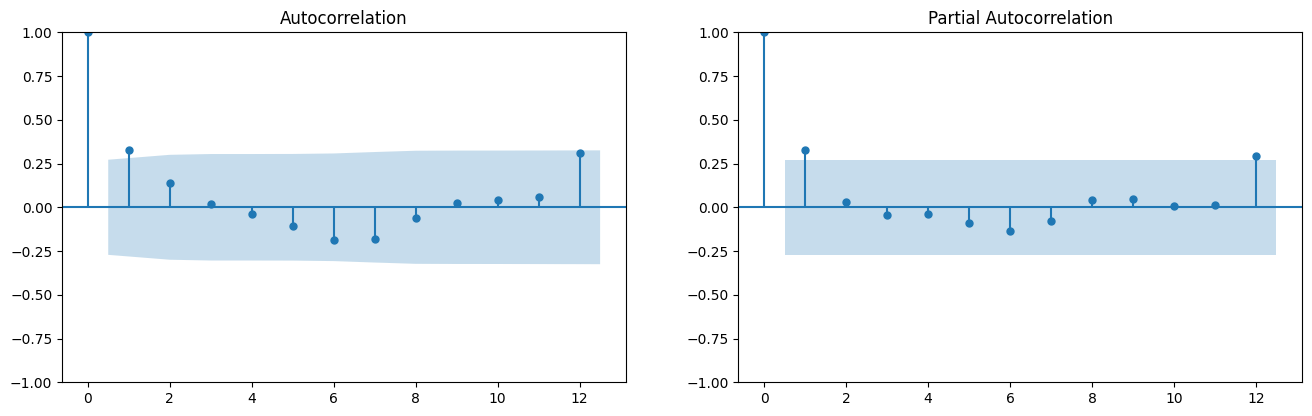

ACF e PACF para o estado: FOODS_3_681


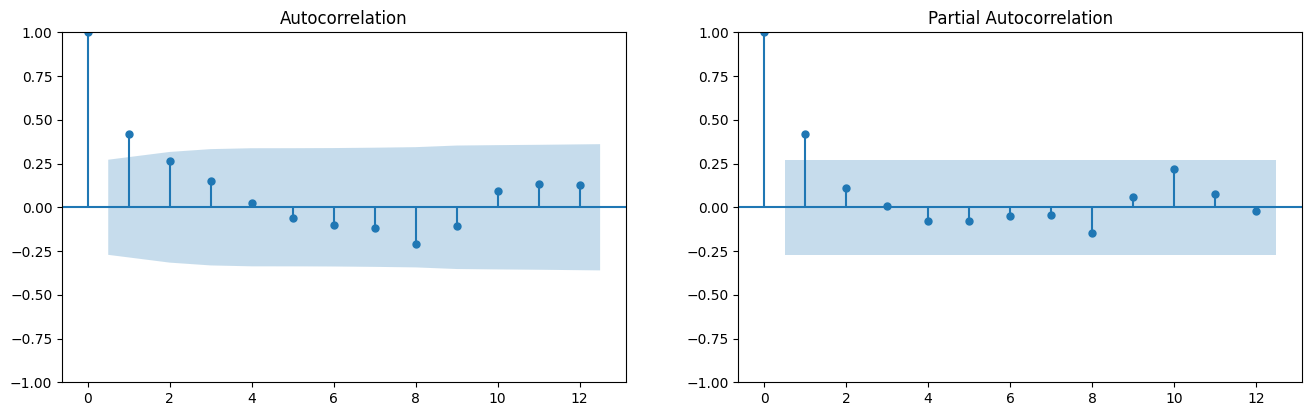

ACF e PACF para o estado: FOODS_3_694


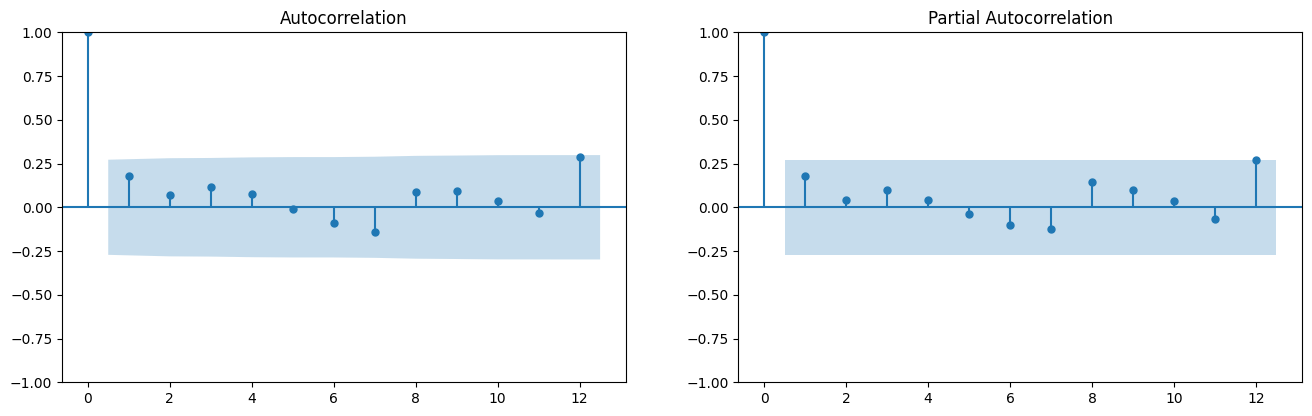

ACF e PACF para o estado: FOODS_3_702


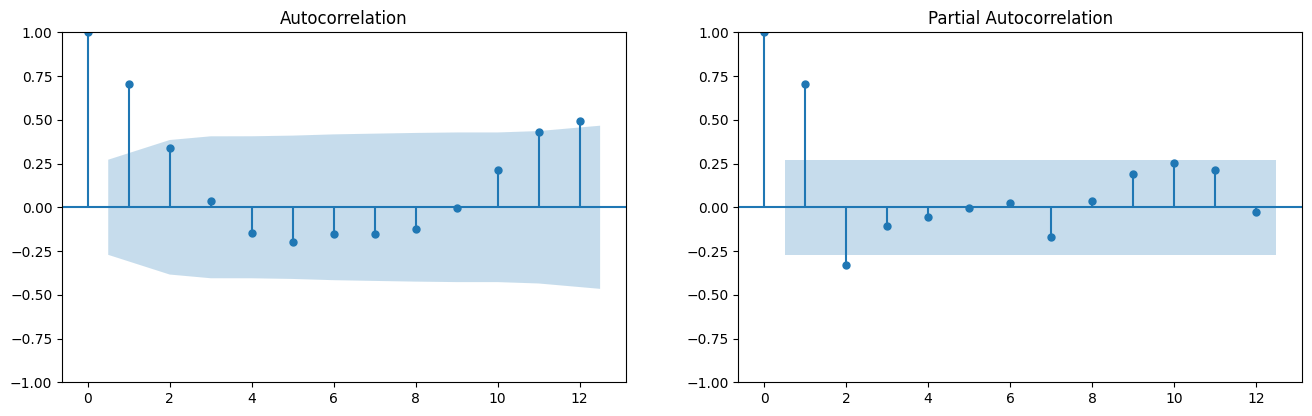

ACF e PACF para o estado: FOODS_3_711


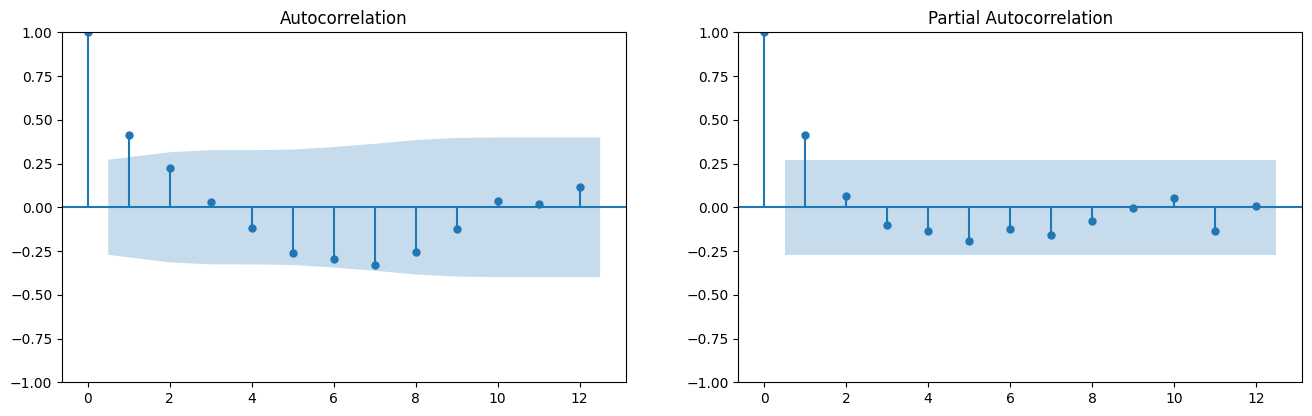

ACF e PACF para o estado: FOODS_3_714


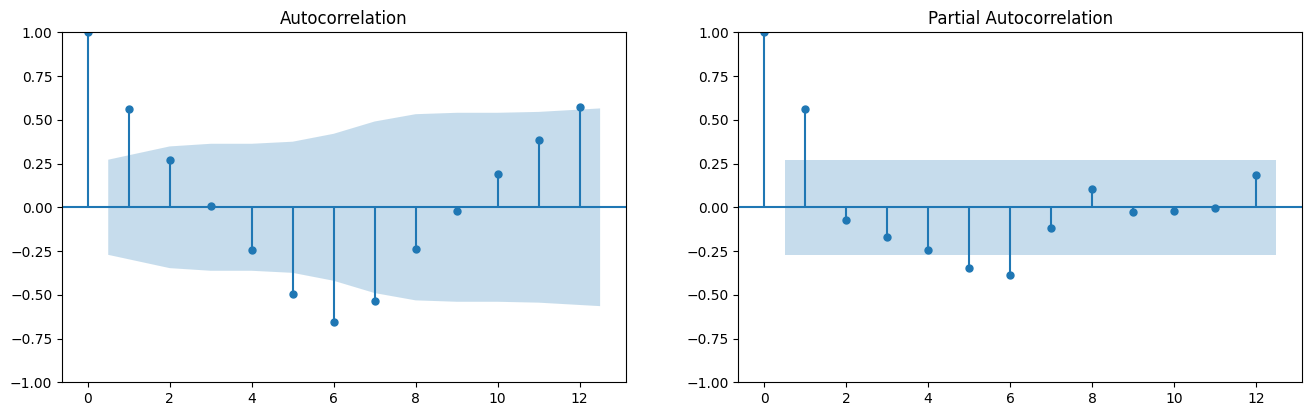

ACF e PACF para o estado: FOODS_3_723


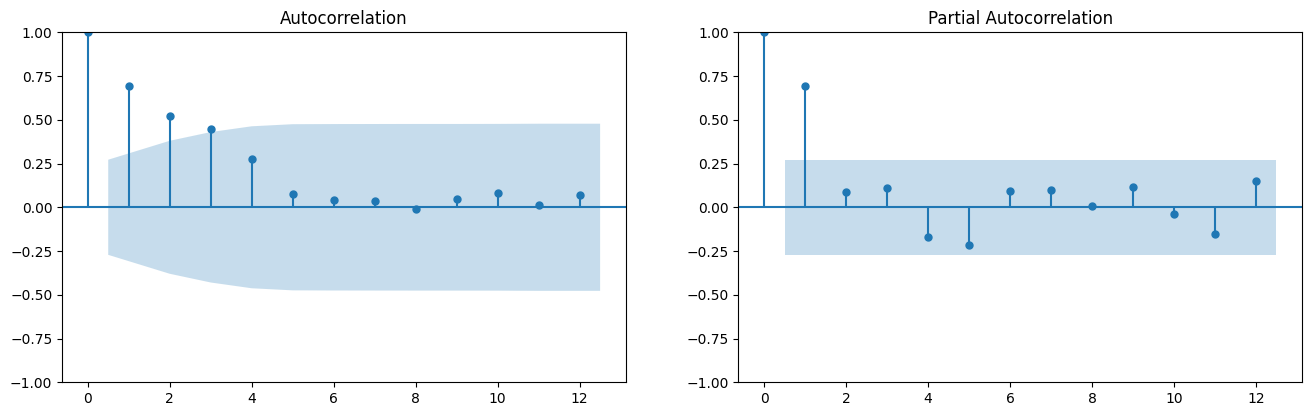

ACF e PACF para o estado: FOODS_3_739


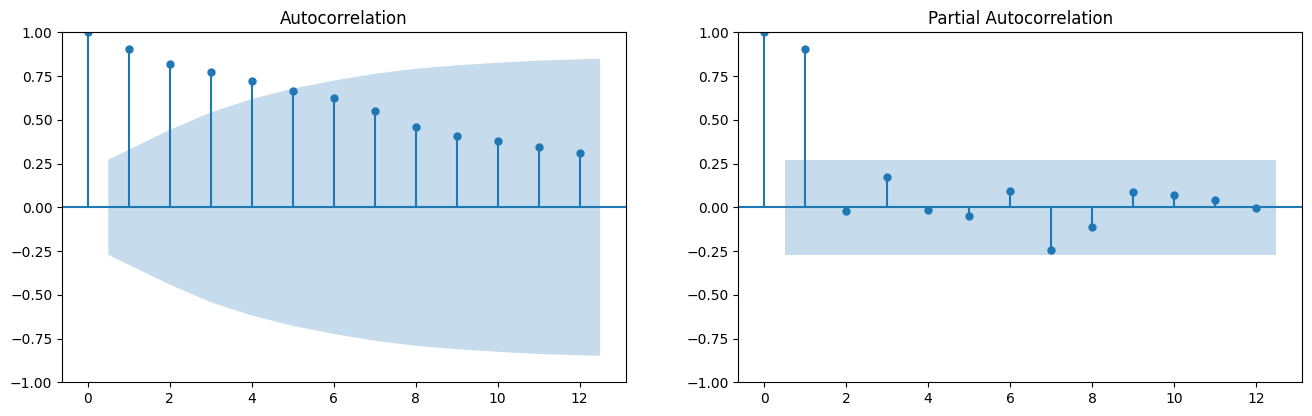

ACF e PACF para o estado: FOODS_3_741


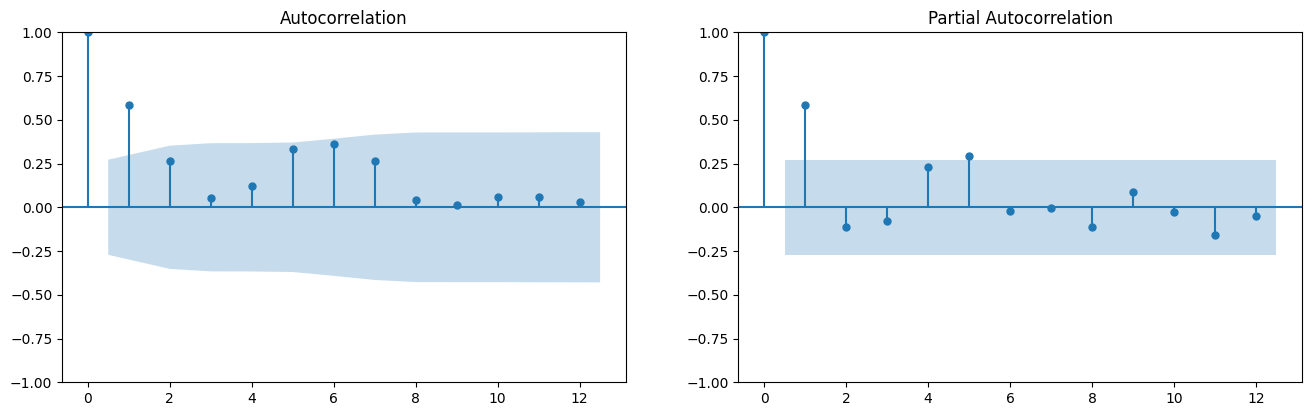

ACF e PACF para o estado: FOODS_3_744


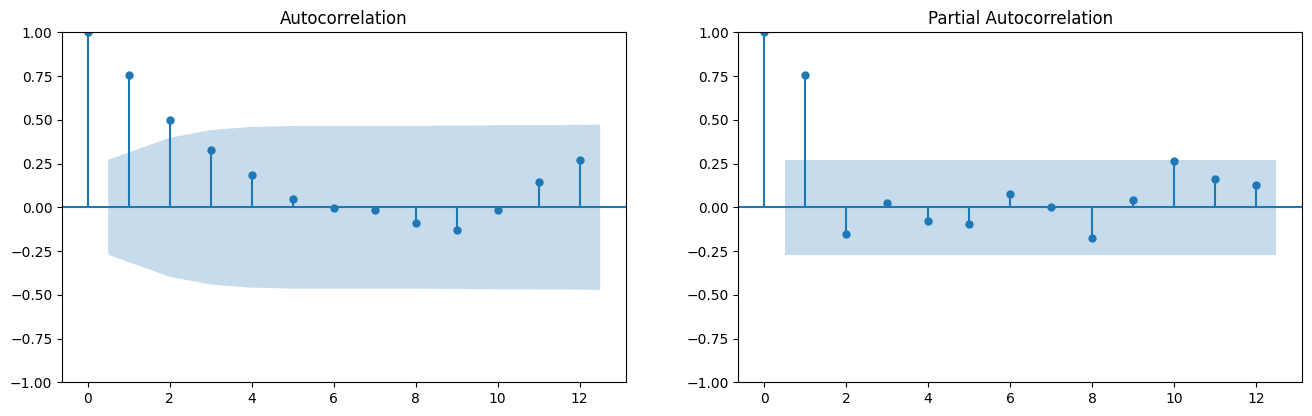

ACF e PACF para o estado: FOODS_3_752


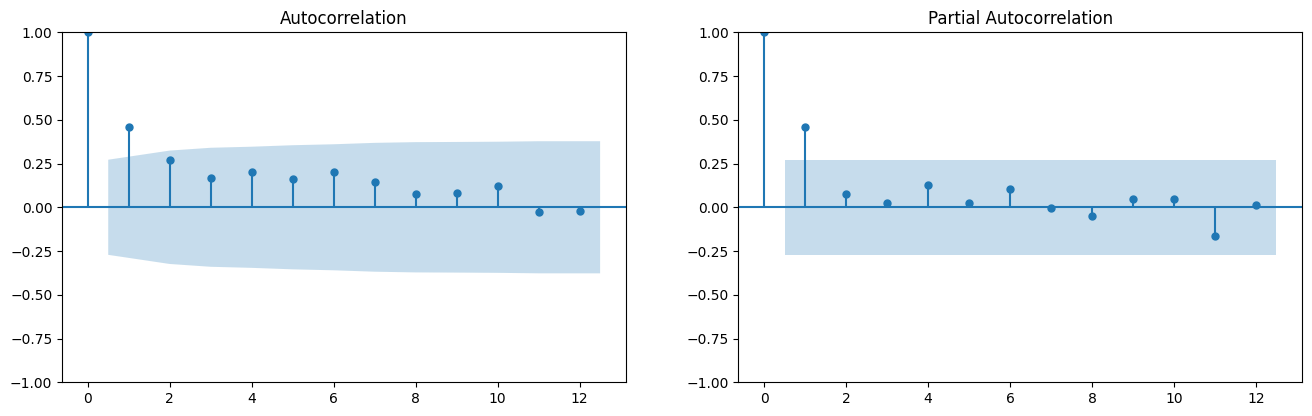

ACF e PACF para o estado: FOODS_3_756


ACF e PACF para o estado: FOODS_3_764


ACF e PACF para o estado: FOODS_3_785


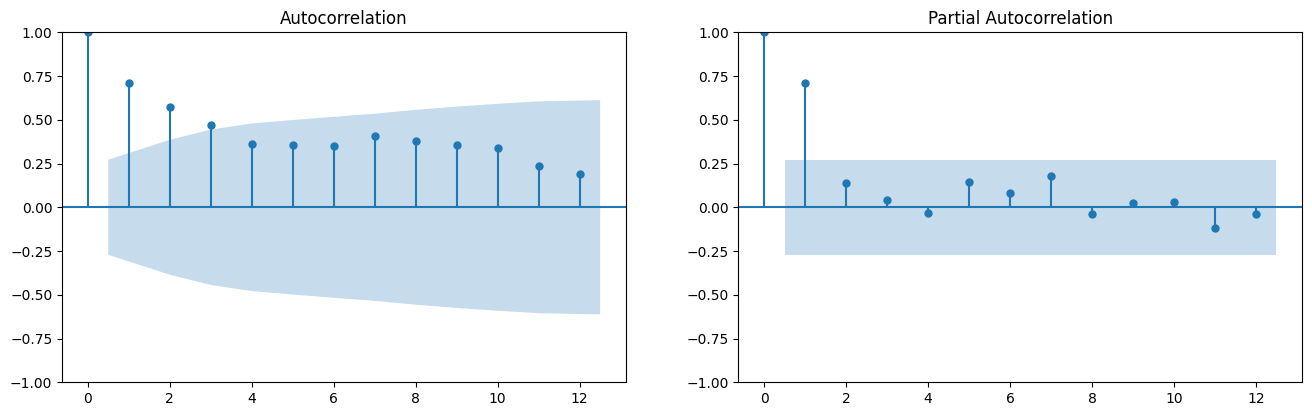

ACF e PACF para o estado: FOODS_3_804


ACF e PACF para o estado: FOODS_3_808


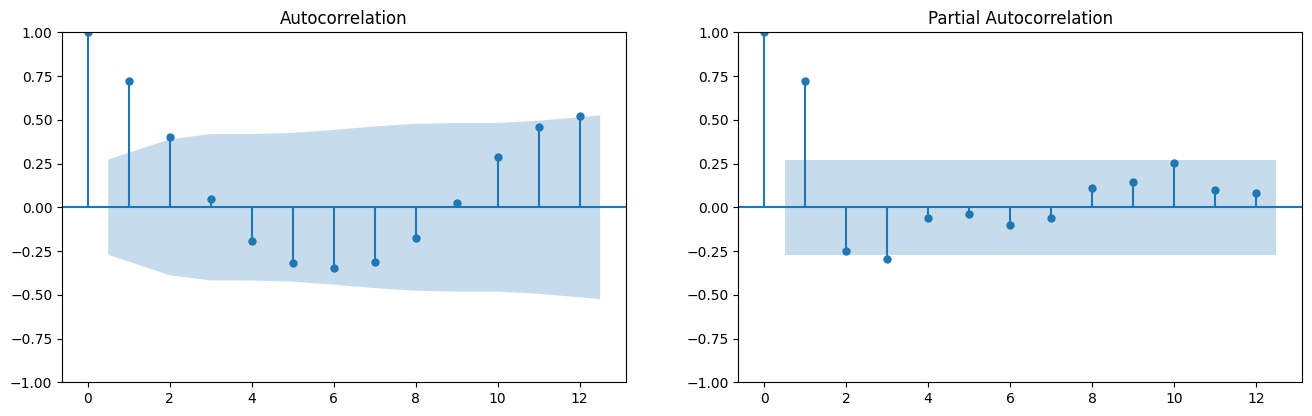

ACF e PACF para o estado: FOODS_3_811


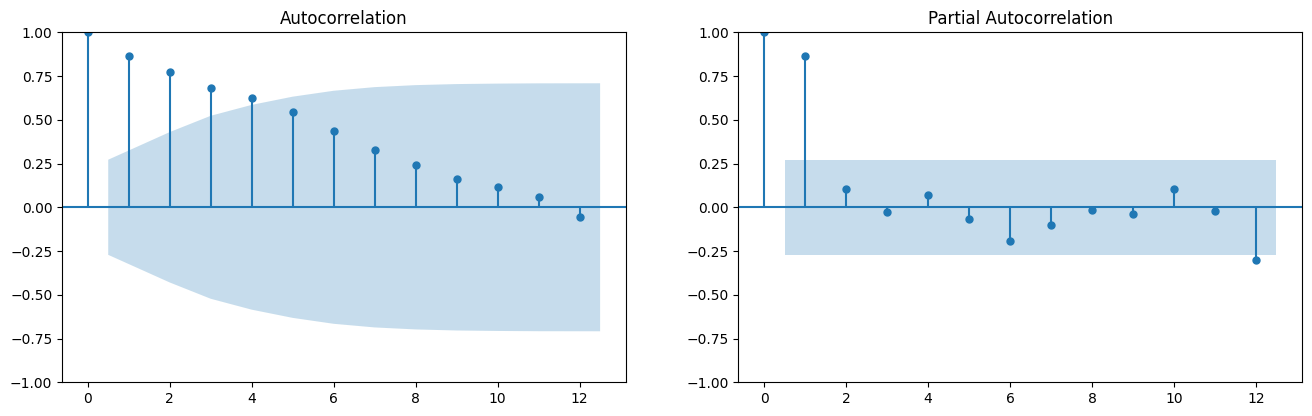

ACF e PACF para o estado: HOBBIES_1_348


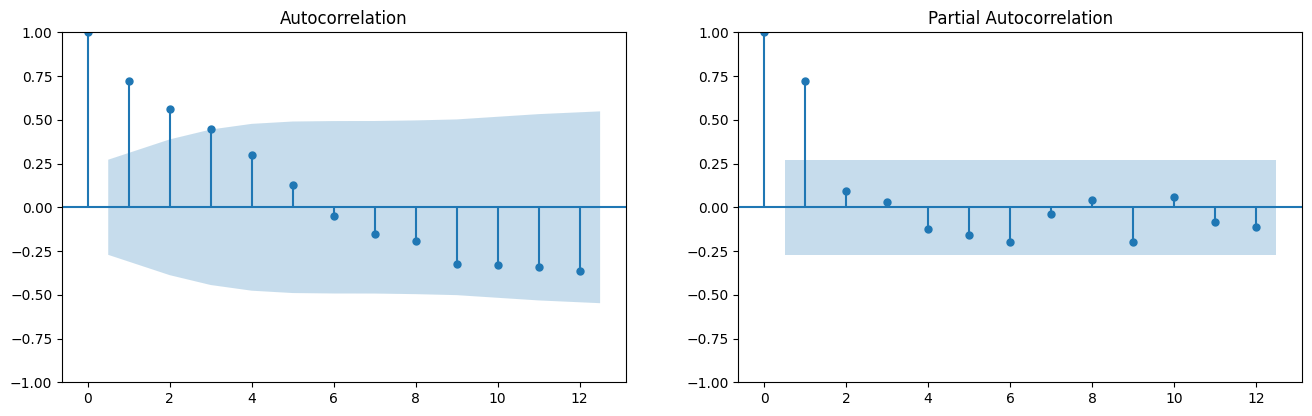

ACF e PACF para o estado: HOBBIES_1_371


ACF e PACF para o estado: HOUSEHOLD_1_019


ACF e PACF para o estado: HOUSEHOLD_1_083


ACF e PACF para o estado: HOUSEHOLD_1_110


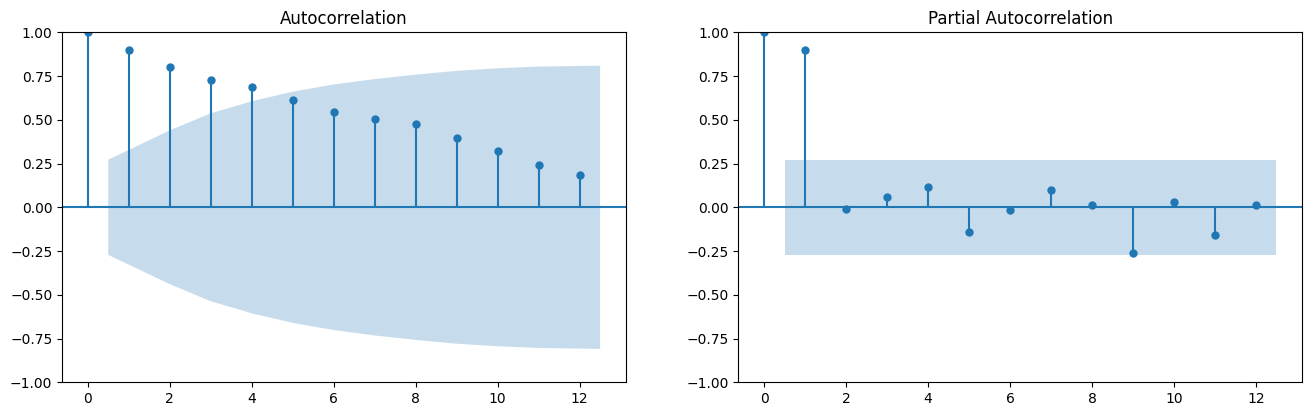

ACF e PACF para o estado: HOUSEHOLD_1_118


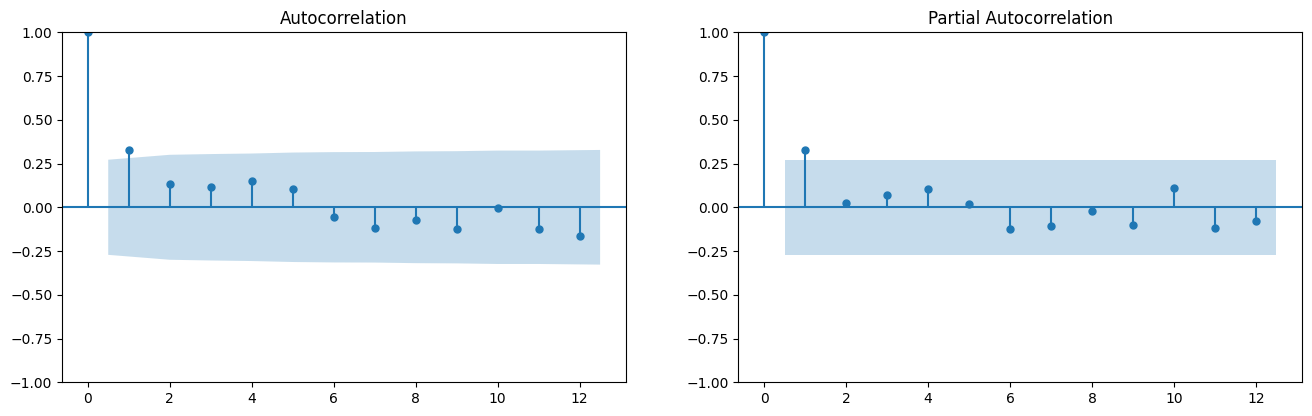

ACF e PACF para o estado: HOUSEHOLD_1_179


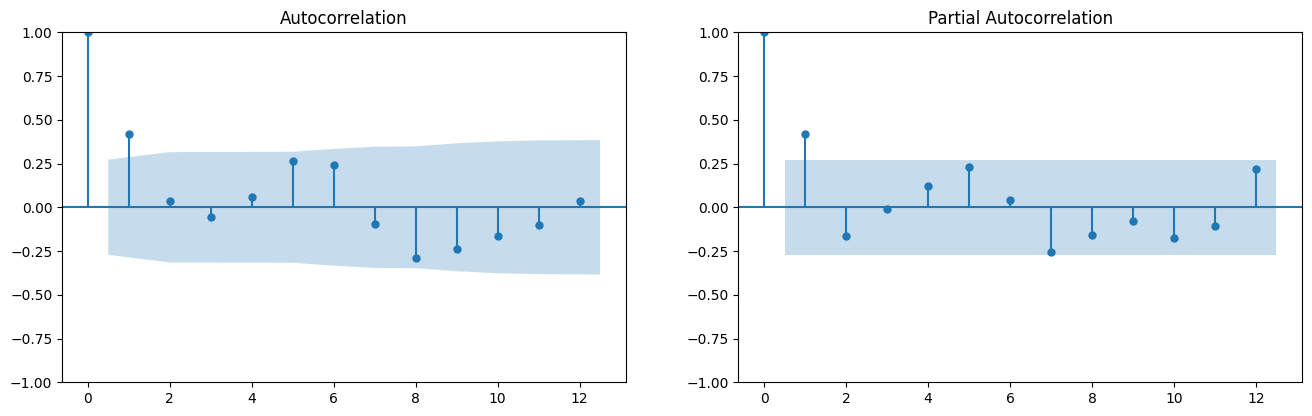

ACF e PACF para o estado: HOUSEHOLD_1_198


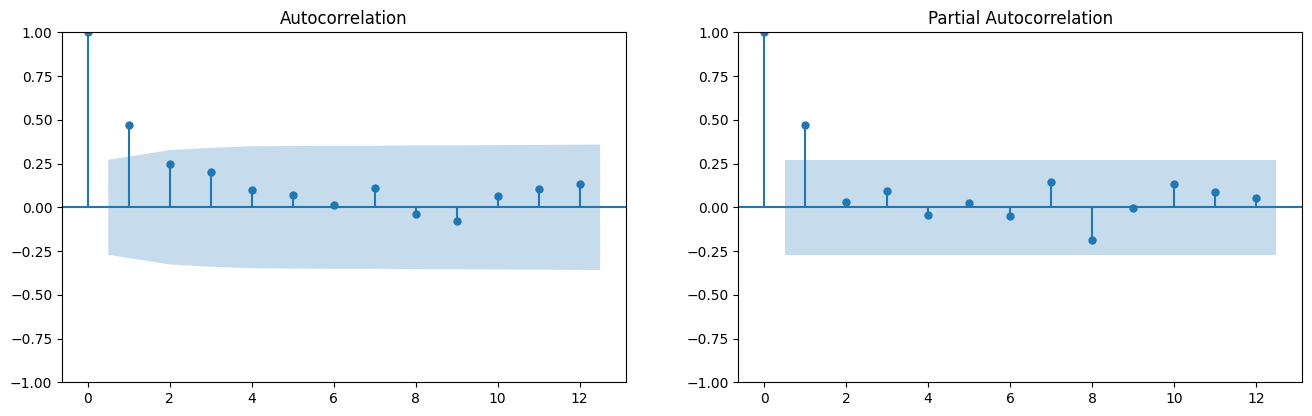

ACF e PACF para o estado: HOUSEHOLD_1_234


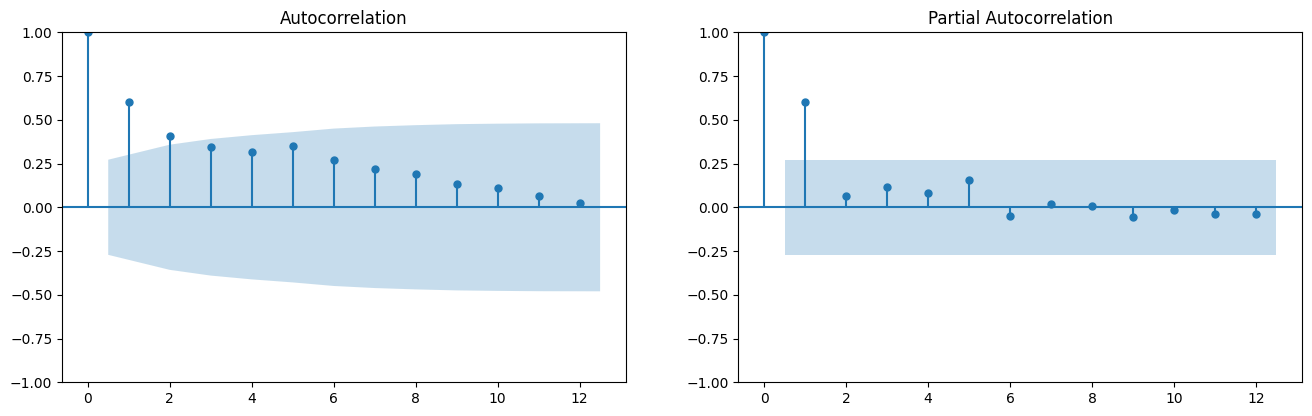

ACF e PACF para o estado: HOUSEHOLD_1_277


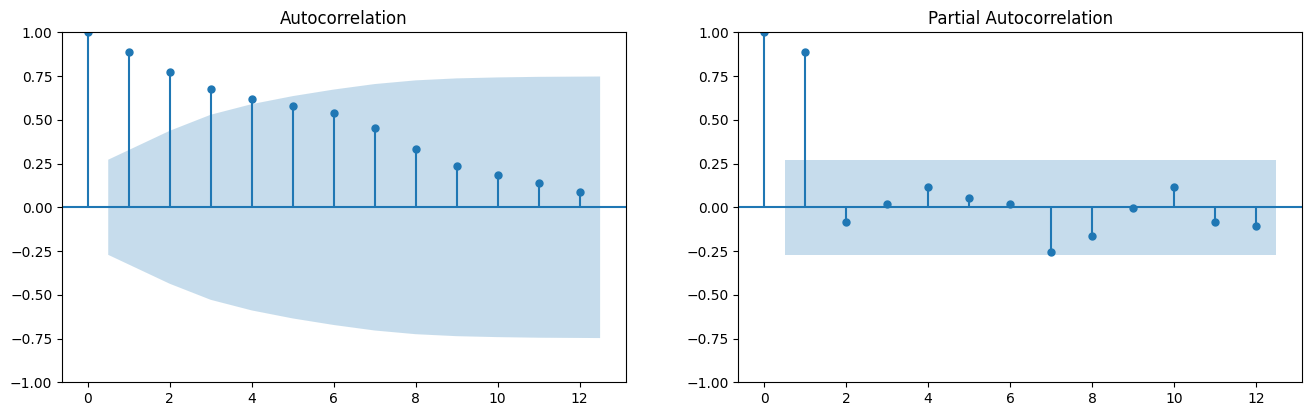

ACF e PACF para o estado: HOUSEHOLD_1_303


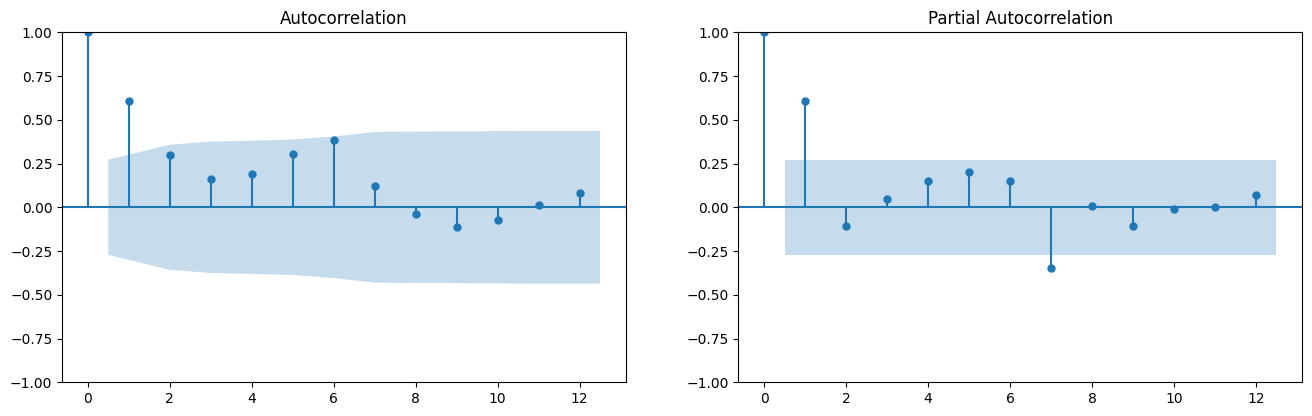

ACF e PACF para o estado: HOUSEHOLD_1_327


ACF e PACF para o estado: HOUSEHOLD_1_334


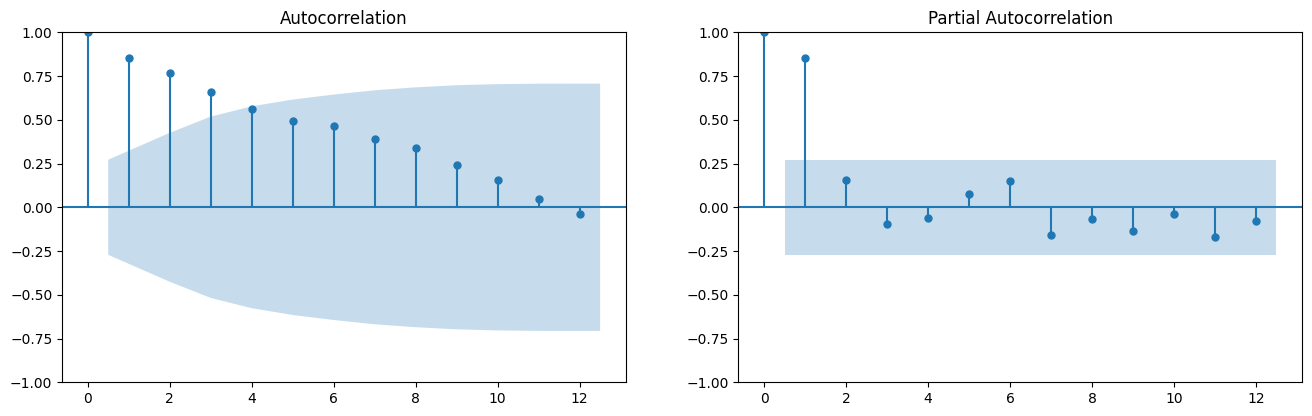

ACF e PACF para o estado: HOUSEHOLD_1_339


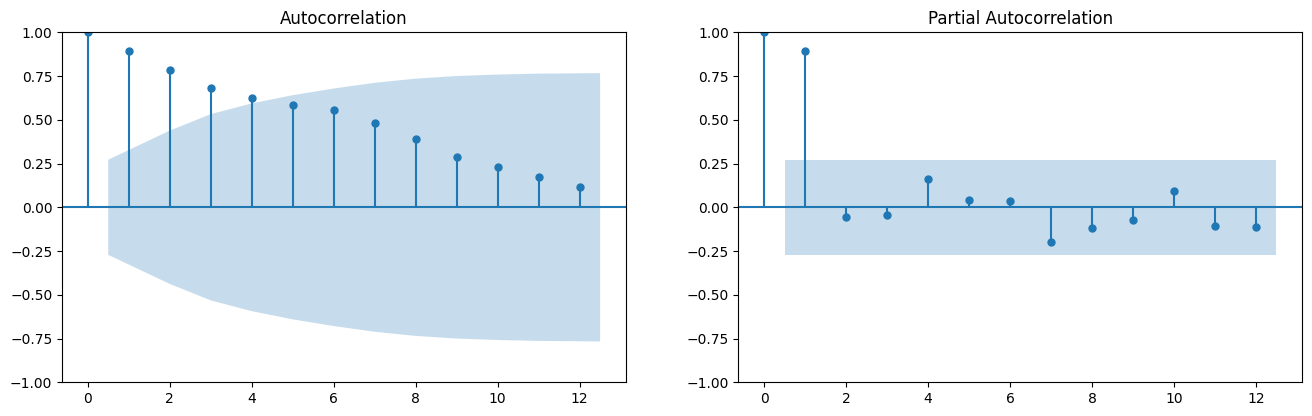

ACF e PACF para o estado: HOUSEHOLD_1_351


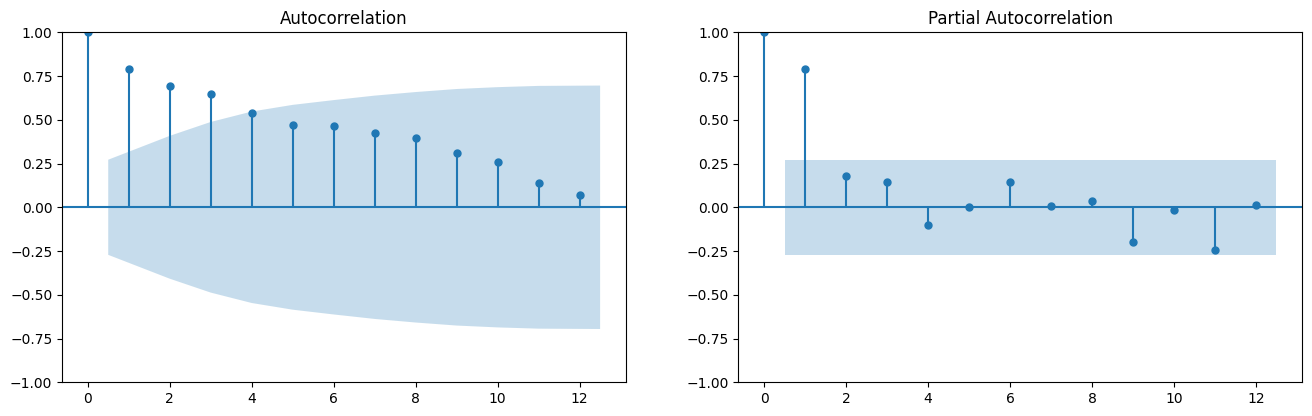

ACF e PACF para o estado: HOUSEHOLD_1_409


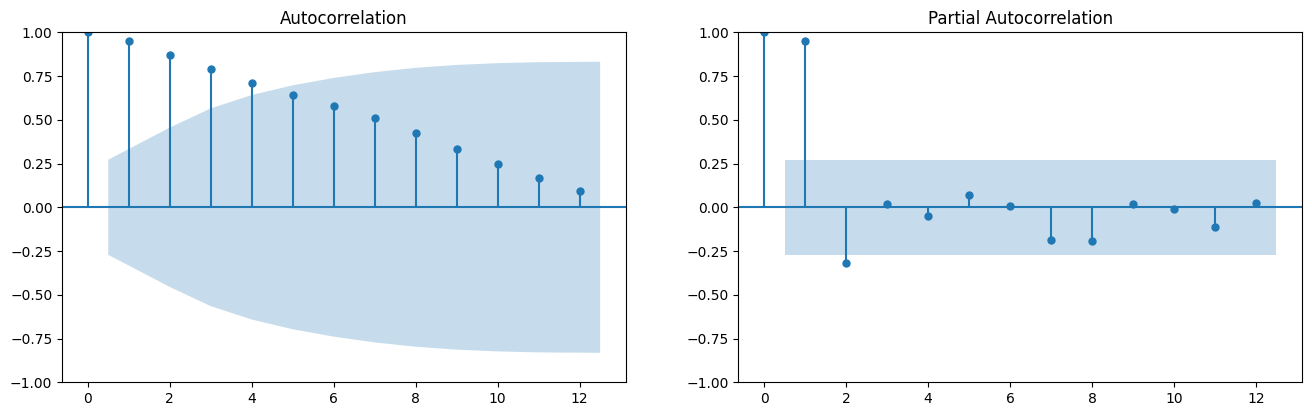

ACF e PACF para o estado: HOUSEHOLD_1_418


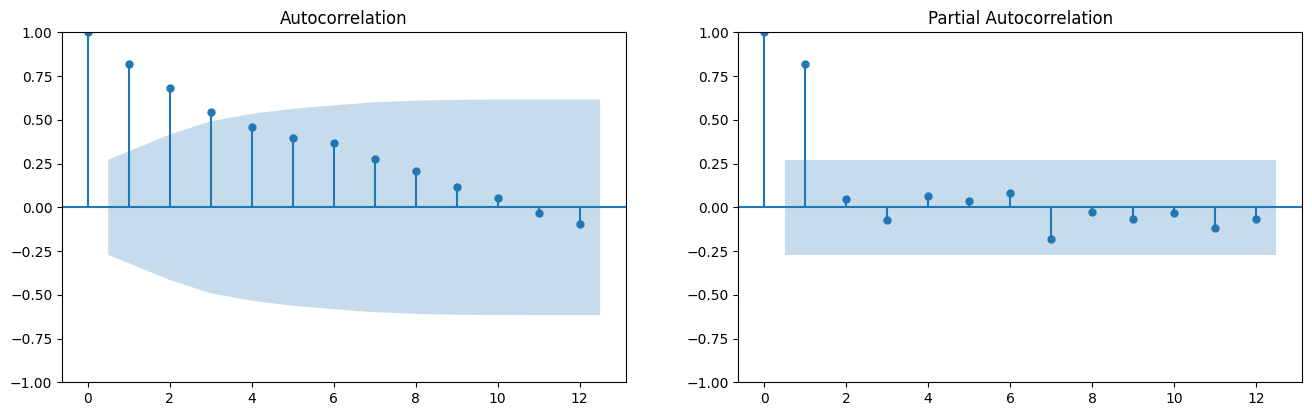

ACF e PACF para o estado: HOUSEHOLD_1_447


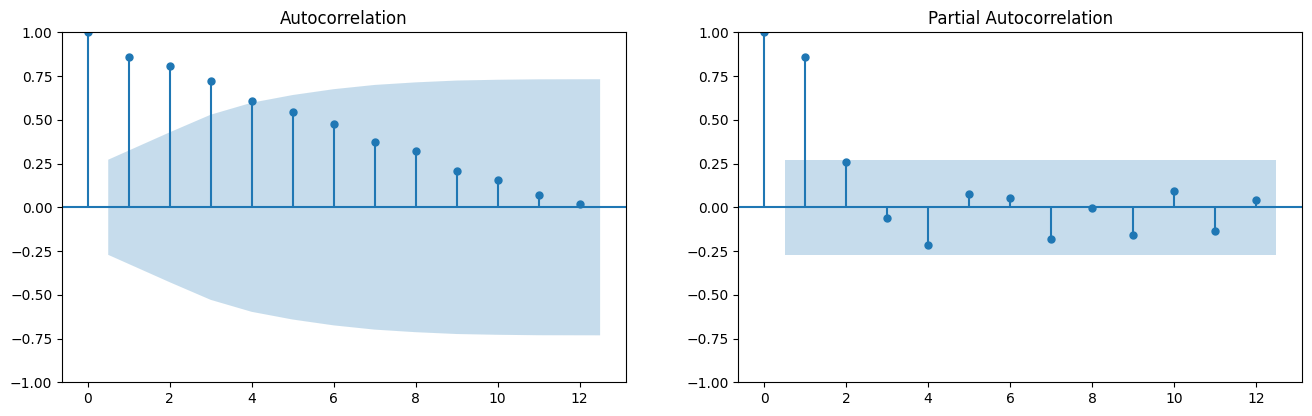

ACF e PACF para o estado: HOUSEHOLD_1_459


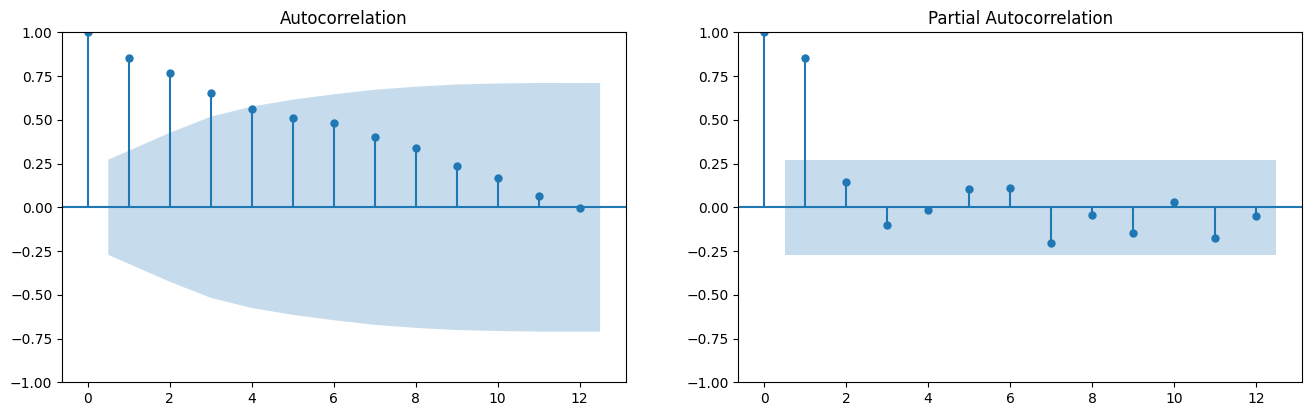

ACF e PACF para o estado: HOUSEHOLD_1_465


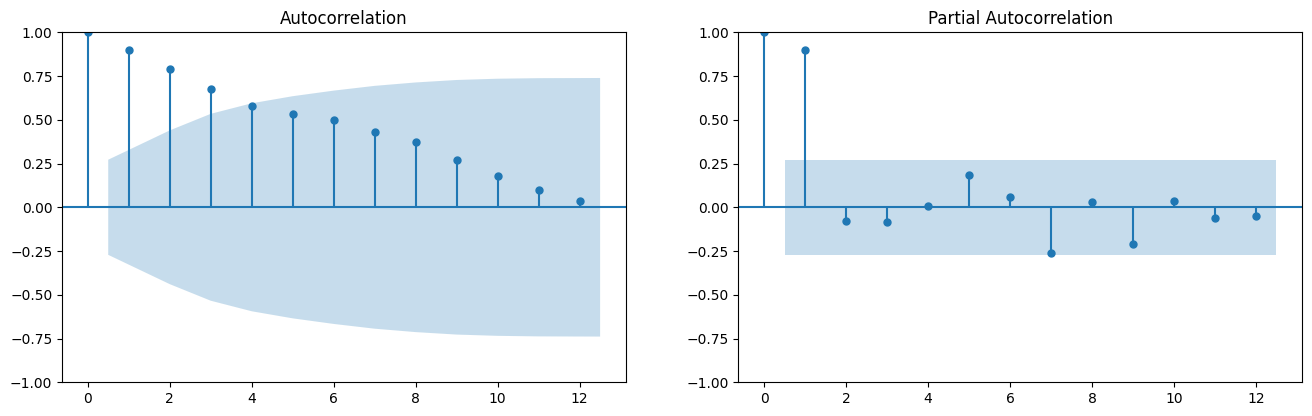

ACF e PACF para o estado: HOUSEHOLD_1_521


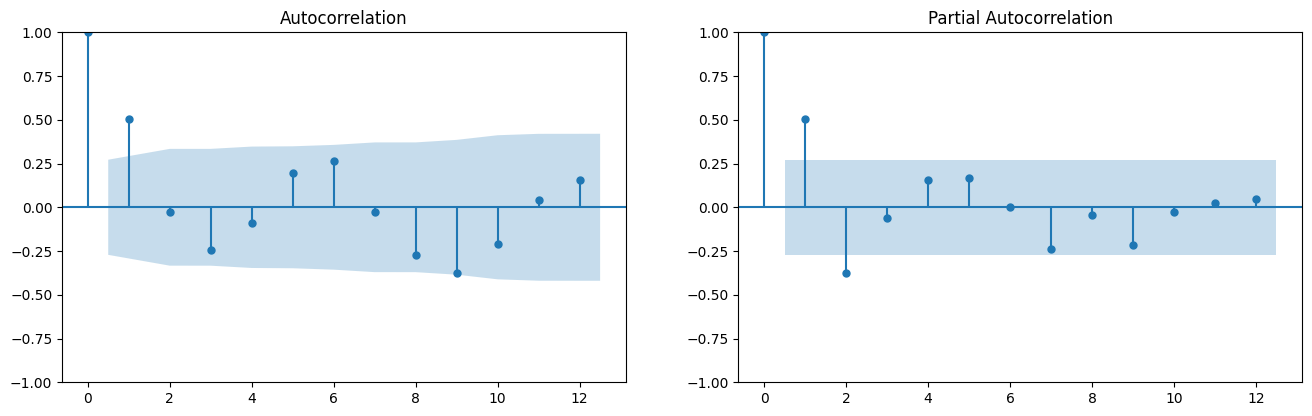

In [ ]:
for state in data_train['unique_id'].unique():
    state_df = data_train[data_train['unique_id'] == state]
    print(f"ACF e PACF para o estado: {state}")
    acf_pacf(state_df['y'], 30)

## Treinamento e previsão do modelo

In [ ]:
models = [
    RandomForestRegressor(n_estimators=50, random_state=0),
    KNeighborsRegressor(n_neighbors=3),
]

In [ ]:
mlf = MLForecast(
    models=models,
    freq='D',
    target_transforms=[LocalMinMaxScaler()],
    lags=[90]
)
mlf.fit(data_train)

MLForecast(models=[RandomForestRegressor, KNeighborsRegressor], freq=D, lag_features=['lag90'], date_features=[], num_threads=1)

In [ ]:
forecasts = mlf.predict(395)

In [ ]:
data_test = data_test.merge(forecasts, how='left', on=['unique_id', 'ds'])

In [ ]:
data_test

unique_id         ds    y  RandomForestRegressor  \
0          FOODS_1_004 2015-04-30  105              64.602158   
1          FOODS_1_004 2015-05-01  157             123.890282   
2          FOODS_1_004 2015-05-02  139              80.303871   
3          FOODS_1_004 2015-05-03  127             130.936279   
4          FOODS_1_004 2015-05-04  121              95.670082   
...                ...        ...  ...                    ...   
38895  HOUSEHOLD_1_521 2016-05-18   46              54.748512   
38896  HOUSEHOLD_1_521 2016-05-19   34              59.353054   
38897  HOUSEHOLD_1_521 2016-05-20   74              48.176926   
38898  HOUSEHOLD_1_521 2016-05-21   67              95.736122   
38899  HOUSEHOLD_1_521 2016-05-22   47              61.863365   

       KNeighborsRegressor  
0                94.000000  
1               117.000000  
2                79.333328  
3               140.666656  
4               105.333336  
...                    ...  
38895           113.613297  
38896            86.329117  
38897            95.359993  
38898            35.756687  
38899           112.340424  

[38900 rows x 5 columns]

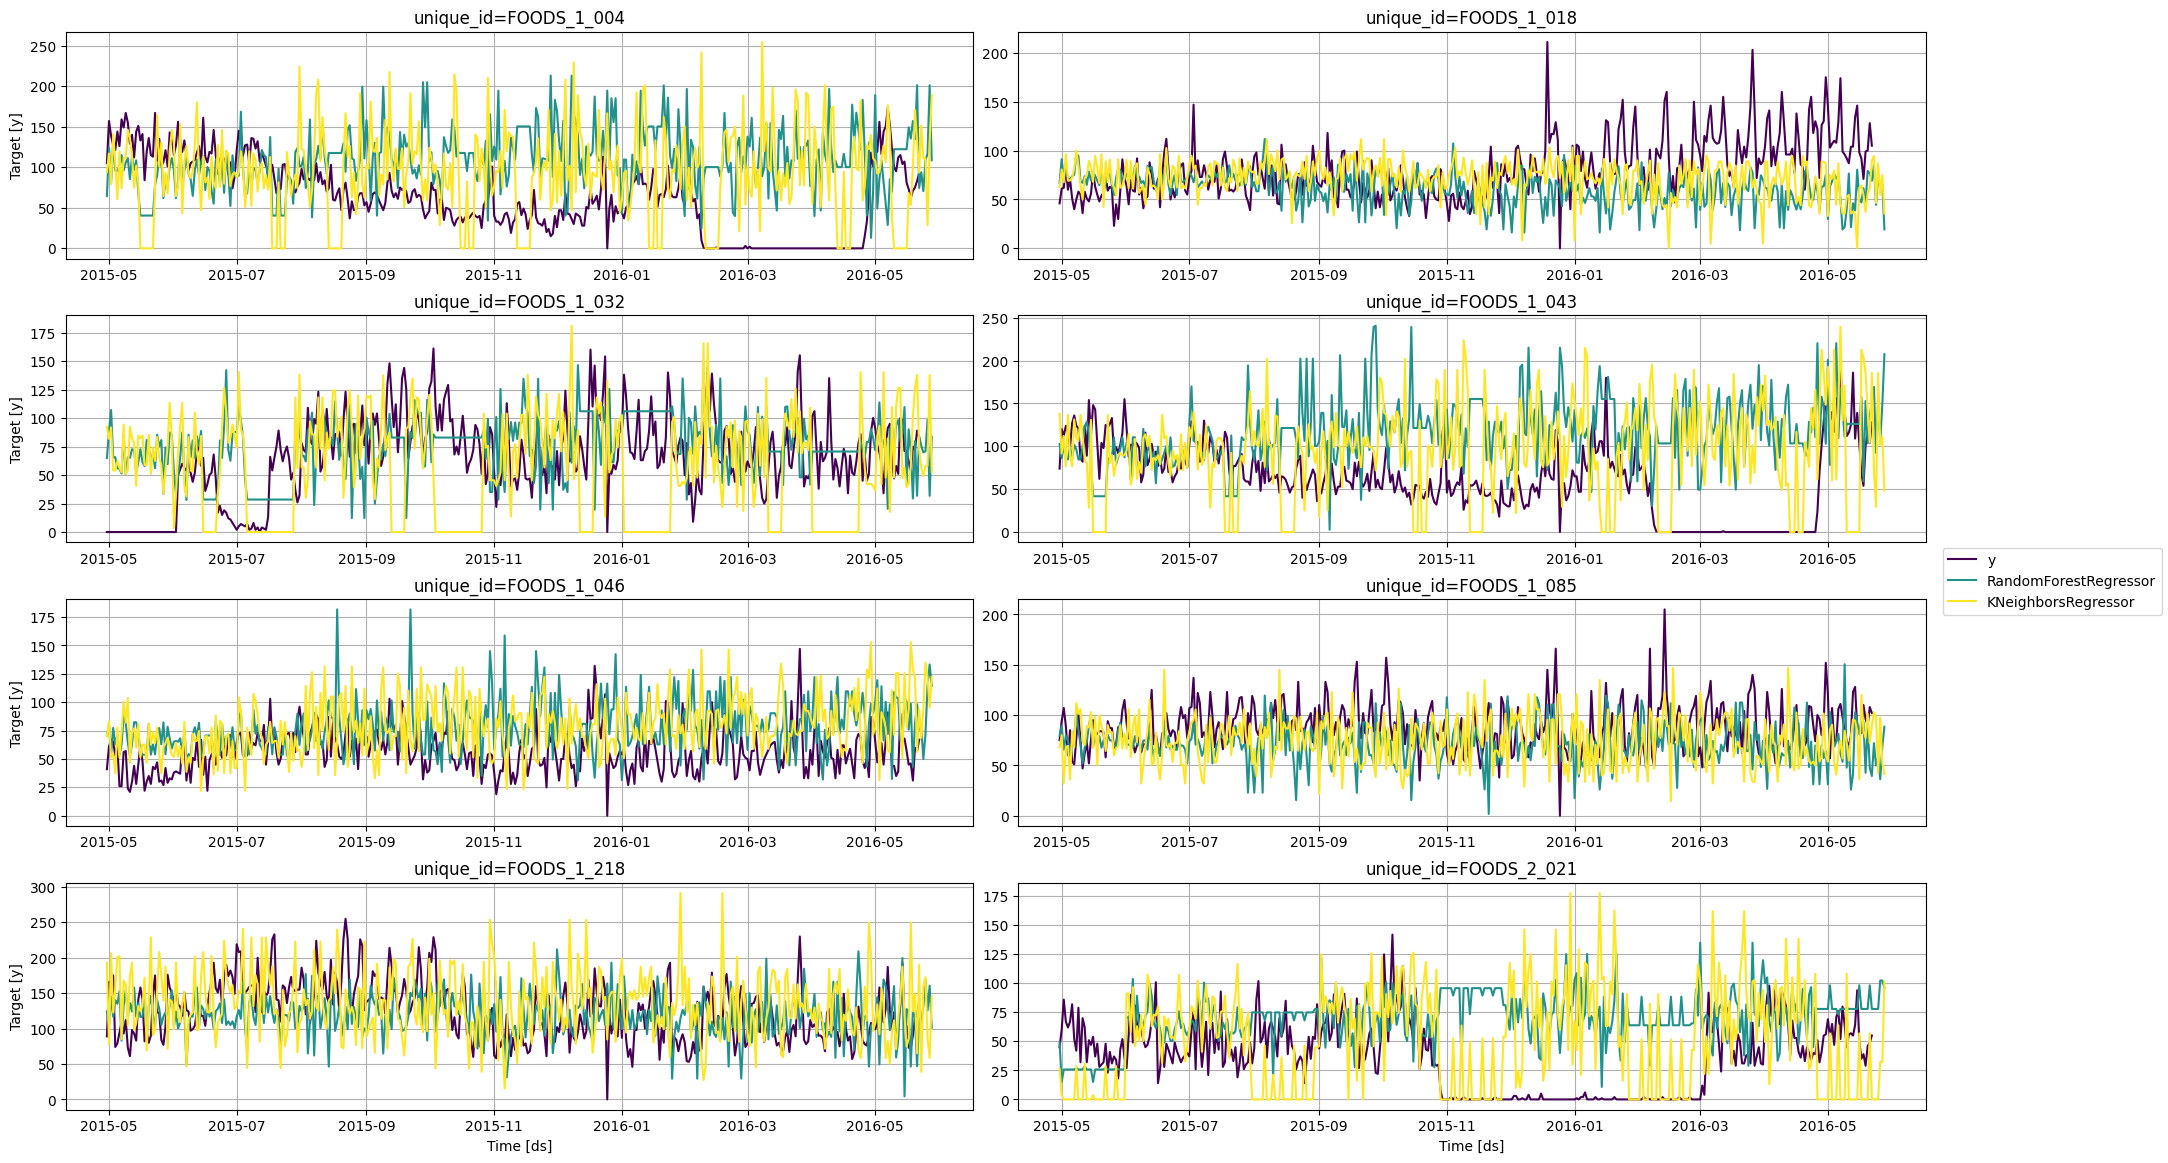

In [ ]:
plot_series(data_test, forecasts, plot_random=False)

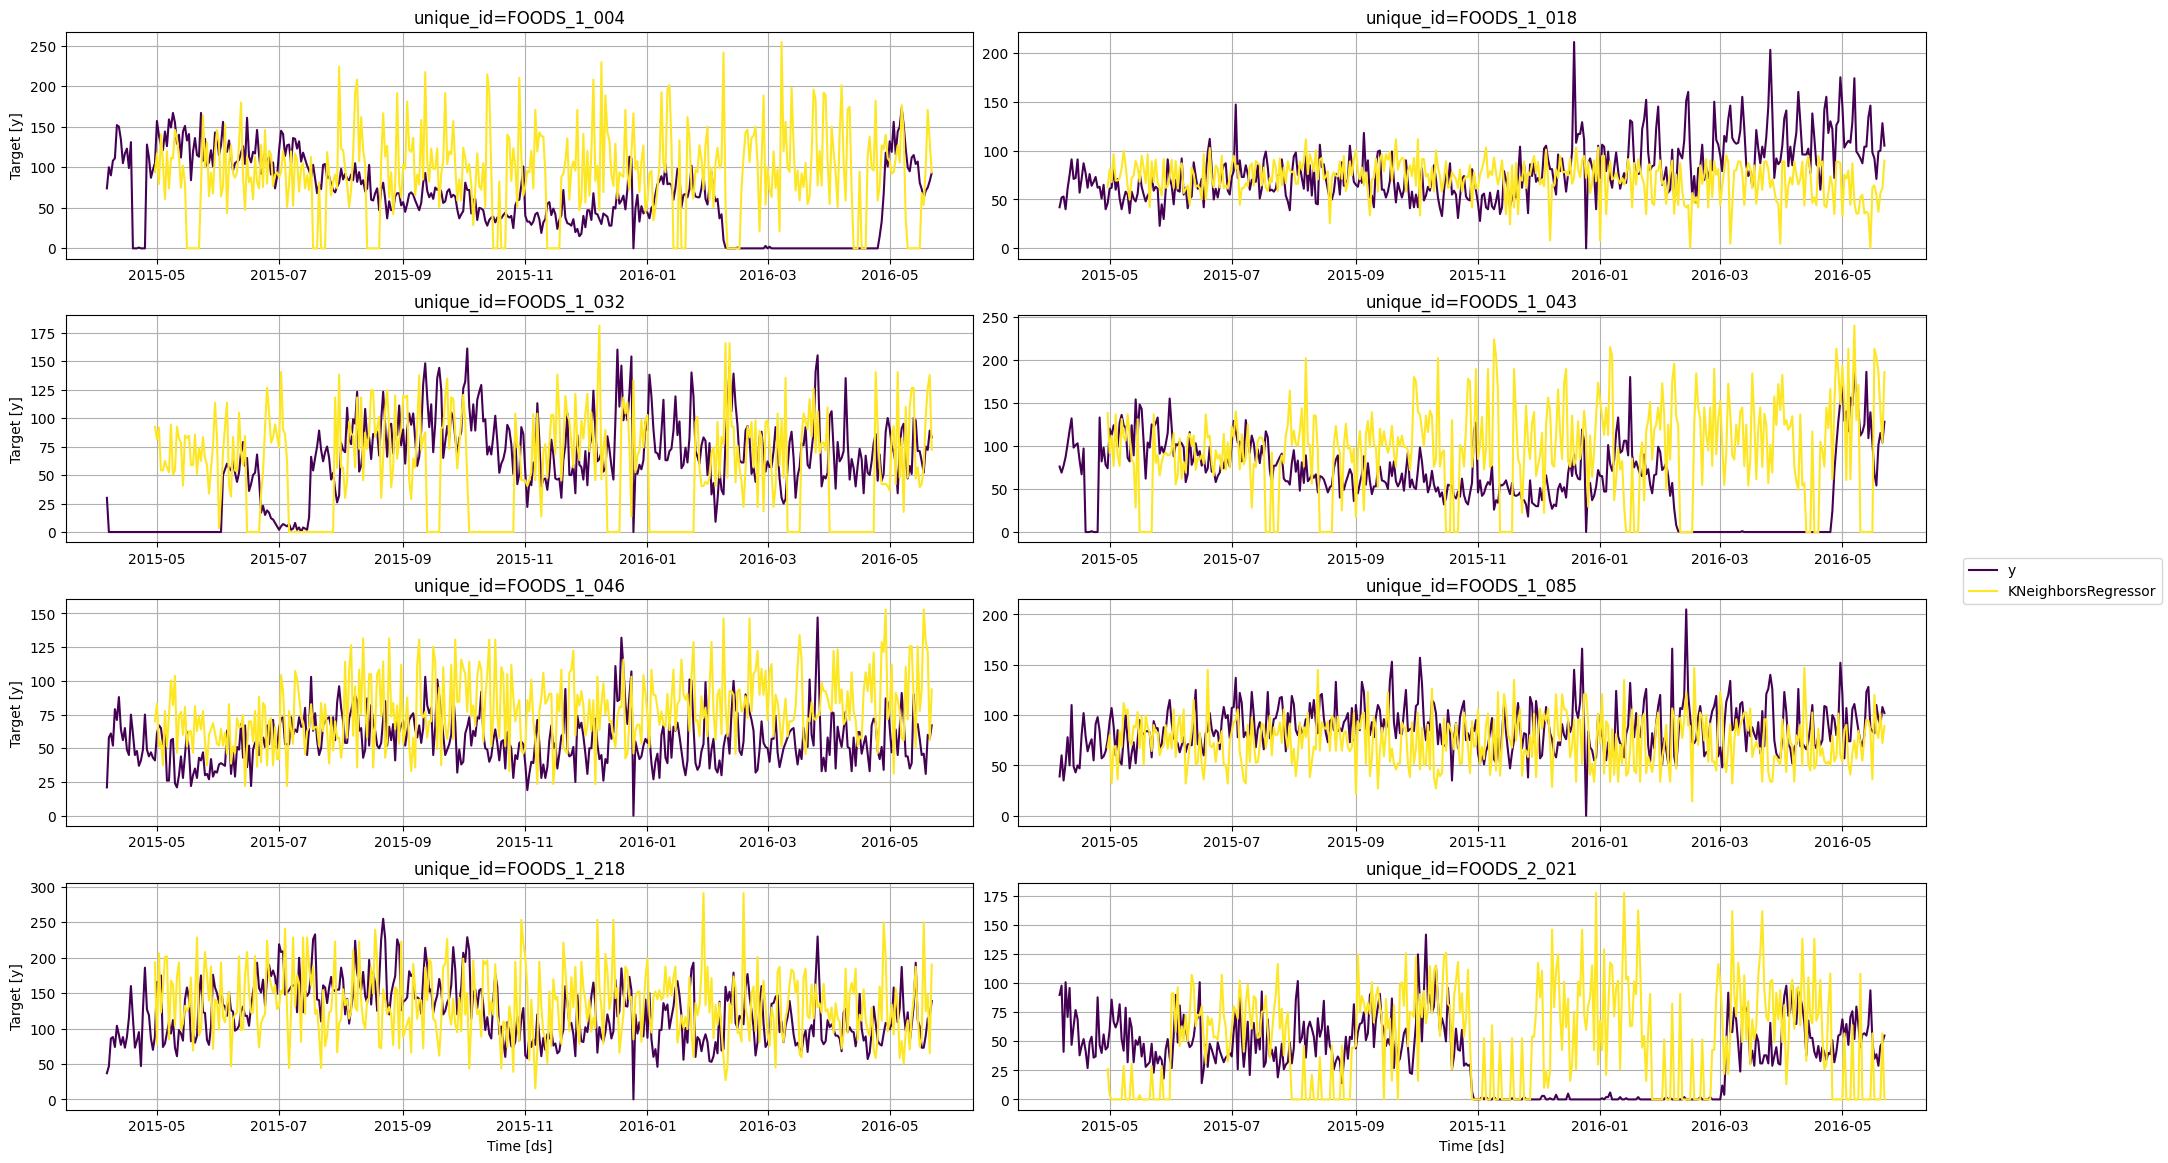

In [ ]:
fig = plot_series(
    data_train,
    data_test,
    plot_random=False,
    models=['KNeighborsRegressor'],
    max_insample_length=24
)
fig

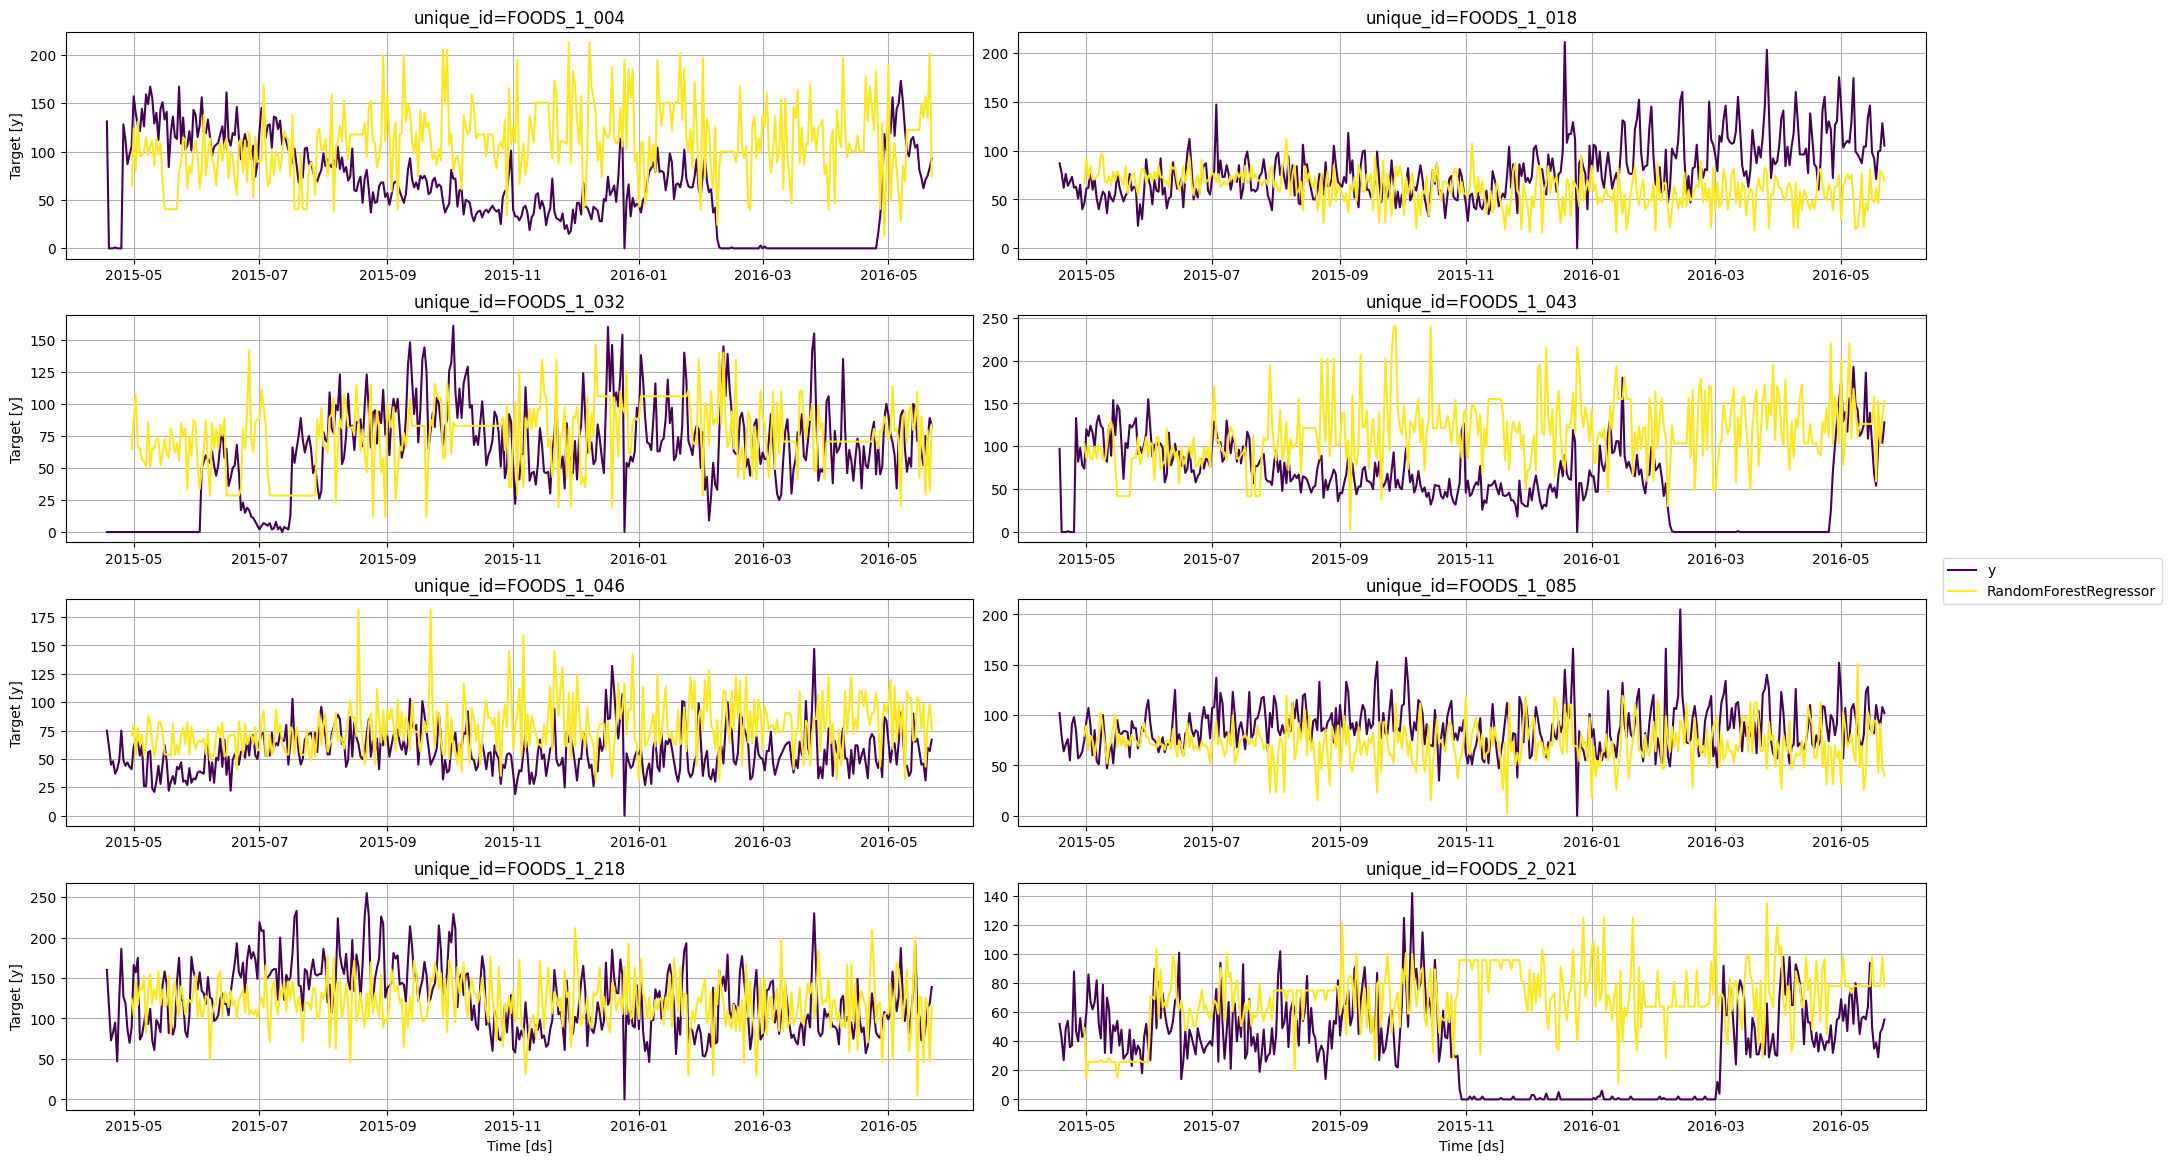

In [ ]:
fig = plot_series(
    data_train,
    data_test,
    plot_random=False,
    models=['RandomForestRegressor'],
    max_insample_length=12
)
fig

In [ ]:

# Inicializar listas para armazenar as métricas
metrics = []

# Calcular as métricas para cada unique_id
unique_ids = data_test['unique_id'].unique()
for unique_id in unique_ids:
    subset = data_test[data_test['unique_id'] == unique_id]
    y_true = subset['y']

    # Previsões do RandomForestRegressor
    y_pred_rf = subset['RandomForestRegressor']
    mae_rf = mean_absolute_error(y_true, y_pred_rf)
    mse_rf = mean_squared_error(y_true, y_pred_rf)
    r2_rf = r2_score(y_true, y_pred_rf)
    mape_rf = MAPE(y_true, y_pred_rf)

    # Previsões do KNeighborsRegressor
    y_pred_knn = subset['KNeighborsRegressor']
    mae_knn = mean_absolute_error(y_true, y_pred_knn)
    mse_knn = mean_squared_error(y_true, y_pred_knn)
    r2_knn = r2_score(y_true, y_pred_knn)
    mape_knn = MAPE(y_true, y_pred_knn)

    # Adicionar métricas ao dataframe
    metrics.append({
        'unique_id': unique_id,
        'MAE_RF': mae_rf,
        'MSE_RF': mse_rf,
        'R2_RF': r2_rf,
        'MAPE_RF': mape_rf,
        'MAE_KNN': mae_knn,
        'MSE_KNN': mse_knn,
        'R2_KNN': r2_knn,
        'MAPE_KNN': mape_knn
    })

# Criar um DataFrame com as métricas
metrics_df = pd.DataFrame(metrics)

# Exibir o DataFrame
metrics_df

unique_id     MAE_RF       MSE_RF     R2_RF       MAPE_RF  \
0       FOODS_1_004  66.509186  6305.391602 -2.097778  9.678349e+16   
1       FOODS_1_018  31.321644  1708.020386 -0.955953  7.133412e+14   
2       FOODS_1_032  34.067451  1785.310303 -0.366181  2.780076e+16   
3       FOODS_1_043  65.662910  6520.876465 -2.665306  1.073637e+17   
4       FOODS_1_046  28.402830  1306.347534 -2.668130  1.347707e+15   
..              ...        ...          ...       ...           ...   
95  HOUSEHOLD_1_418  32.026905  1666.213013 -1.045373  1.136691e+15   
96  HOUSEHOLD_1_447  27.646446  1247.160767 -1.016417  7.925302e+14   
97  HOUSEHOLD_1_459  38.192562  2542.198486 -1.059344  1.131198e+15   
98  HOUSEHOLD_1_465  33.731071  1904.291748 -1.523277  6.424249e+14   
99  HOUSEHOLD_1_521  29.112661  1378.329346 -0.246168  1.151247e+15   

      MAE_KNN      MSE_KNN    R2_KNN      MAPE_KNN  
0   60.372780  5893.046387 -1.895197  8.302205e+16  
1   28.384390  1486.153442 -0.701880  8.335712e+14  
2   49.216431  3567.463379 -1.729947  2.798074e+16  
3   62.051144  5981.337891 -2.362037  8.326977e+16  
4   31.511679  1474.213257 -3.139485  5.341980e+14  
..        ...          ...       ...           ...  
95  41.071621  2697.571777 -2.311426  7.067018e+14  
96  31.141672  1513.979126 -1.447810  5.983820e+14  
97  41.142170  2570.319580 -1.082124  5.980481e+14  
98  35.927910  2067.150146 -1.739072  7.840370e+14  
99  35.253471  1918.338013 -0.734397  1.086201e+15  

[100 rows x 9 columns]

## Previsão 6 meses

In [ ]:
mlf_full = MLForecast(
    models=models,
    freq='D',
    target_transforms=[LocalMinMaxScaler()],
    lags=[90]
)
mlf_full.fit(data_full)

MLForecast(models=[RandomForestRegressor, KNeighborsRegressor], freq=D, lag_features=['lag90'], date_features=[], num_threads=1)

In [ ]:
previsao_6meses = mlf_full.predict(180)

In [ ]:
previsao_6meses

unique_id         ds  RandomForestRegressor  KNeighborsRegressor
0          FOODS_1_004 2016-05-23              44.168480             0.000000
1          FOODS_1_004 2016-05-24              44.168480             0.000000
2          FOODS_1_004 2016-05-25              44.168480             0.000000
3          FOODS_1_004 2016-05-26              44.168480             0.000000
4          FOODS_1_004 2016-05-27              44.168480             0.000000
...                ...        ...                    ...                  ...
17995  HOUSEHOLD_1_521 2016-11-14             109.317871           107.184830
17996  HOUSEHOLD_1_521 2016-11-15              28.104904           108.428574
17997  HOUSEHOLD_1_521 2016-11-16              80.286514            30.366196
17998  HOUSEHOLD_1_521 2016-11-17             106.006905            74.333336
17999  HOUSEHOLD_1_521 2016-11-18              60.328617            61.666672

[18000 rows x 4 columns]

## Exportando pkl

In [ ]:
with open('ModelosPKL/vendas_top_100_Itens.pkl', 'wb') as f:
    pickle.dump(mlf_full, f)

## Exportando Previsão 6 meses

In [ ]:
previsao_6meses.to_csv('Previsoes/previsao_vendas_Top_100_Itens.csv', index=False)